The process can be defined from ($\varphi, \lambda, Q$) where
* $\varphi$ is the ODE dynamics - or the integral path defined by a vector field $\Phi$
* $\lambda$ is the probability that a jumps occurs during the particle's movement
* $Q$ is the Markov kernel used for the jump

ZigZag sampler:

* $\Phi(x, v)$ = v
* $\lambda(x, v)_i = (v_i (\partial \psi(x))_i)_+$, with $\pi \propto \exp(-\psi(x))$ the target distribution. For Gaussian distribution: $$\lambda(x, v)_i = (v_i x_i)_+ $$
* Q reverses speed.

For the reverse process, we essentially just need to compute, for all $i$:
$$ \bar \lambda_i = \lambda_i \dfrac{p_t(x_t, R_i v_t)}{p_t(x_t, v_t)} $$
Notations:
$$ s_{\theta}(x, R v, t) = \begin{pmatrix} s_{\theta}(x, R_1 v, t)_1 \\ \cdots \\ s_{\theta}(x, R_d v, t)_d \end{pmatrix}$$
where $R_i v = \begin{pmatrix} v_1 \\ \cdot \\ -v_i \\ \cdot \\ v_n \end{pmatrix}$
* Fit the model by minimizing:
     $$ \mathbb{E}_{t, x, v} \|  s_{\theta}(x, v, t) - \dfrac{p_t(x_t, R v_t)}{p_t(x_t, v_t)}\|^2 =  \mathbb{E}_{t, x, v} \frac12 s_{\theta}(x, v, t)^2 - s_{\theta}(x, R v, t)$$



Current Limitations
* If the dimension is $d$, we need $d+1$ forward pass, because:
$$ \mathbb{E}_{t, x, v} \frac12 s_{\theta}(x, v, t)^2 - s_{\theta}(x, R v, t) = \mathbb{E}_{t, x, v} \sum_{i=1}^d \frac12 s_{\theta}(x, v, t)_i^2 - s_{\theta}(x, R_i v, t)_i$$
* The loss is unstable.

**Symmetrised ratio matching** we introduce the function $g(r) = \frac{1}{1+r}$ and define the objective function
\begin{equation}
    J_{ERM}(\theta) = \sum_{i=1}^d \mathbb{E}_{p_t}\left[ \left(g(s_\theta(X_t,V_t,t)[i]) - g(r_i(X_t,V_t,t)) \right)^2 + \left(g(s_\theta(X_t,R_iV_t,t)[i]) - g(r_i(X_t,R_iV_t,t)) \right)^2 \right]
\end{equation}
which is equivalent, as an objective function, to:
\begin{equation}
    J_{IRM}(\theta) = \sum_{i=1}^d \mathbb{E}_{p_t}\left[ \frac{1}{(1 + s_\theta(x,v,t)[i])^2} +\frac{1}{(1 + s_\theta(x,R_i v,t)[i])^2}  - \frac{2}{1 + s_\theta(x,v,t)[i]}\right]
\end{equation}


**KL minimisation** Focus on the score entropy:
\begin{equation}
    J_{ERM}(\theta) =  \sum_{i=1}^d w_i\mathbb{E}_{p_t}\left[ s_\theta(X_t,V_t,t)[i] -r_i(X_t,V_t,t)  - \Big( \log s_\theta(X_t,R_iV_t,t)[i]) - \log r_i(X_t,R_iV_t,t)\Big) \right].
\end{equation}
where $\{w_i\}$ is a sequence of weights. Also this objective function considers the error in the estimation of both $r_i(x,v,t)$ and $r_i(x,R_iv,t)$, encouraging stable solutions. Clearly the implicit formulation has objective function 
\begin{equation}
    J_{IRM}(\theta) =  \sum_{i=1}^d w_i\mathbb{E}_{p_t}\left[ s_\theta(X_t,V_t,t)[i] -  \log s_\theta(X_t,R_iV_t,t)[i]) \right].
\end{equation}


TODO:
* Mixing time of pdmp (time horizon?). (Andrea)
* Dimension problem. Think of it today: first architecture is outputting (Dario)
$$r_t(x, v)_1, r_t(x, R_1v)_1, \cdots$$ 
Second one: (Dario)
$$r_t(x, 1, v_{[2:d]})_1, r_t(x, -1, v_{[2:d]})_1, \cdots$$
Third one: (Andrea)
Coordinate descent on the loss 
* Monte-Carlo to plot real density ratio, 1d and 2d, compare with model. (Dario)
* Add evaluation metrics, and loss metrics. (Dario)
* Experiments: 
    * Other datasets. $\mathcal{N}(\mu, \sigma^2 I_2)$ instead of mixture. (Dario).
    * Increase dimensions of the data distribution (Dario).
    * Study effect of the number of reverse steps. Effect of the backward sampling (spliting scheme) (Dario)


Connect to github, maybe andrea has his own branch, and then you can update the code. 


* Architecture. Change the network architecture. Receives $R$ as an argument, and is made invariant on speed?
    $$ s_{\theta}(x, v, R) : \quad  s_{\theta}(x, Rv, R) = s_{\theta}(x, v, R)$$ 
    Take the component $i$ as an input. Idea of copula? Take a single dimension as input too? outputs a single value.

# PDMP

## Playground

In [1]:
# Import required packages
import torch
import numpy as np
import normflows as nf
import zuko

from matplotlib import pyplot as plt

from tqdm import tqdm

In [2]:
# Neural spline flow (NSF) with 3 sample features and 5 context features
model = zuko.flows.NSF(2, 1, transforms=3, hidden_features=[128] * 3)

In [22]:
# Set up model

# Define 2D Gaussian base distribution
base = nf.distributions.base.DiagGaussian(2)

# Define list of flows
num_layers = 32
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1+1, 64, 64, 2], init_zeros=True) # 3 additional condition dimensions
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(base, flows)

In [3]:
# Move model on GPU if available
enable_cuda = True
device = 'mps' #torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

In [4]:
# Define target distribution
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

num_samples = 10000
target_0 = nf.distributions.TwoMoons().sample(num_samples)
context_0 = torch.zeros(num_samples).unsqueeze(-1)
target_1 = nf.distributions.CircularGaussianMixture().sample(num_samples)
context_1 = torch.ones(num_samples).unsqueeze(-1)
target = torch.cat((target_0, target_1), dim=0)
context = torch.cat((context_0, context_1), dim=0)
# shuffle entries of target
idx = torch.randperm(target.shape[0])
target = target[idx]
context = context[idx]

dataset = TensorDataset(target, context) #attached a class to the data, will be useful on other datasets
data = DataLoader(dataset, 
                batch_size=target.shape[0] // 8, 
                shuffle=True, 
                num_workers=0)

In [5]:
loss_hist = np.array([])
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5) # 5e-4

  0%|                                                                                                                                              | 0/125 [00:00<?, ?it/s]

  1%|█                                                                                                                                     | 1/125 [00:00<01:32,  1.34it/s]

Loss:  tensor(3.6815, device='mps:0', grad_fn=<MeanBackward0>)


 41%|██████████████████████████████████████████████████████▎                                                                              | 51/125 [00:14<00:20,  3.63it/s]

Loss:  tensor(1.9232, device='mps:0', grad_fn=<MeanBackward0>)


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 101/125 [00:28<00:06,  3.62it/s]

Loss:  tensor(1.8948, device='mps:0', grad_fn=<MeanBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:34<00:00,  3.57it/s]


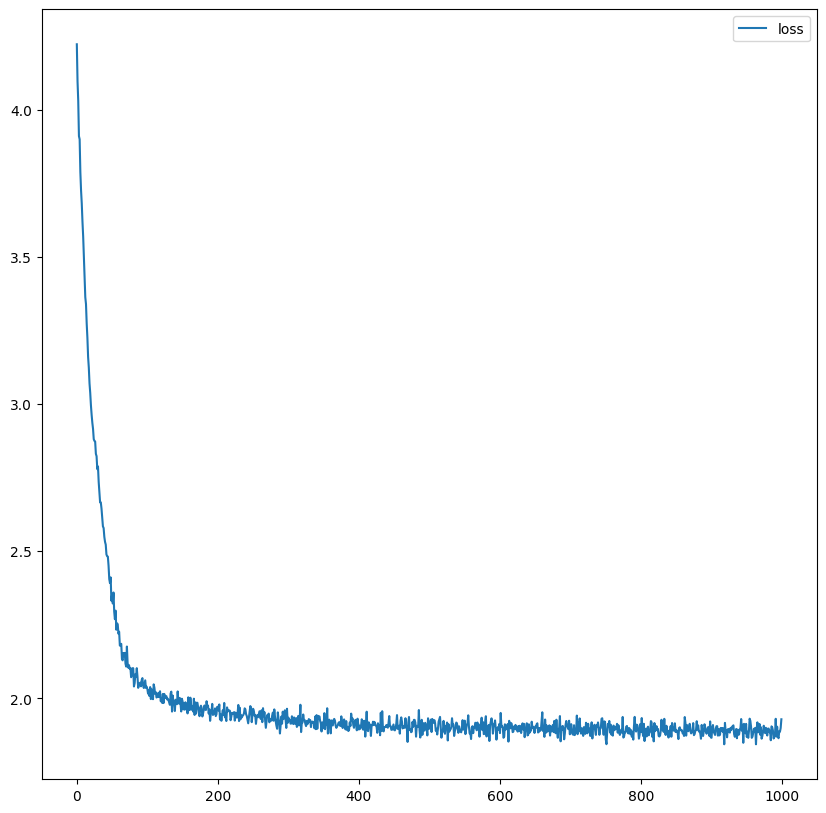

In [6]:
# Train model
max_iter = 1000

it = 0
for it in tqdm(range(0, max_iter, len(data))):
    for _, (x, context) in (enumerate(data)):
        optimizer.zero_grad()
        
        # Get training samples
        #x = target.sample(num_samples).to(device)
        x, context = x.to(device), context.to(device)
        
        # Compute loss
        #loss = model.forward_kld(x, context=context)
        loss = -model(context).log_prob(x)
        loss = loss.mean()

        # Do backprop and optimizer step
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()
        
        # Log loss
        loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    if (it% (50*len(data))) == 0:
        print('Loss: ', loss)
    #print('Loss: ', loss)

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


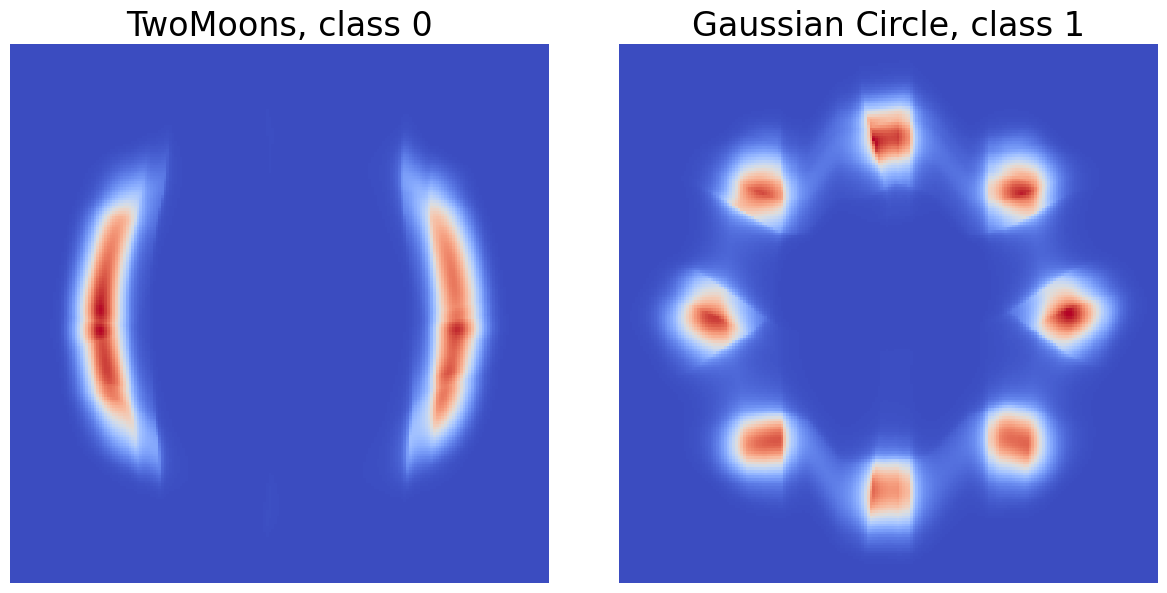

In [7]:
# Plot target distribution
f, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

#log_prob = target.log_prob(zz).to('cpu').view(*xx.shape)
#prob = torch.exp(log_prob)
#prob[torch.isnan(prob)] = 0
# Plot learned distribution
model.eval()
log_prob = model(0*torch.ones(zz.shape[0], 1).to(device)).log_prob(zz).to('cpu').view(*xx.shape) #model.log_prob(zz, 0*torch.ones(zz.shape[0], 1)).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

ax[0].pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')

ax[0].set_aspect('equal', 'box')
ax[0].set_axis_off()
ax[0].set_title('TwoMoons, class 0', fontsize=24)

# Plot learned distribution
model.eval()
log_prob = model(1*torch.ones(zz.shape[0], 1).to(device)).log_prob(zz).to('cpu').view(*xx.shape)#model.log_prob(zz, 1*torch.ones(zz.shape[0], 1)).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

ax[1].pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')

ax[1].set_aspect('equal', 'box')
ax[1].set_axis_off()
ax[1].set_title('Gaussian Circle, class 1', fontsize=24)

plt.subplots_adjust(wspace=0.1)

plt.show()

In [8]:
model(torch.zeros(10, 1).to(device)).sample()

tensor([[-1.6777, -0.5345],
        [-2.1356, -0.8004],
        [-2.1202,  0.3996],
        [ 1.6408, -0.7053],
        [-2.0561,  0.3541],
        [ 1.4756, -0.7327],
        [-2.0652, -0.3607],
        [ 1.7107, -0.3251],
        [-1.9149,  0.9206],
        [ 2.0345, -0.3682]], device='mps:0')

## Setup

* Forward, backward, loss in PDMP class
* Other classes automatically take care of training, evaluation, saving, loading etc

Prepare all our objects:

In [1]:
from IPython.display import HTML
from IPython.display import display
import os
import yaml
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

import numpy as np
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import initial_code.pdmp as PDMP
import Data as Data
from Model import LevyDiffusionModel
import torch.optim as optim
import torch.nn as nn
import Generate as Gen
import matplotlib.pyplot as plt
import evaluate.Eval as Eval
import Manager 
import zuko

%matplotlib inline

p_model_2d = {
    'act' : 'silu',
    'skip_connection' : True,
    'group_norm' : True,
    'dropout_rate' : .0,
    'nblocks' : 32,
    'nunits' : 64,
    'use_a_t' : False,
    'no_a': True,
    'a_pos_emb': False, # cannot have no_a and a_pos_emb
    'a_emb_size': 32,
    'time_emb_type' : 'learnable',#'learnable',# 'one_dimensional_input',
    'time_emb_size' : 8, 
    'compute_gamma': False,
}

p_data_2d = {
    'nfeatures' : 2, # if data_type is 2d, will just project on first dimension
    'nsamples' : 4*8*1024,
    #'bs': ..., may need to add
    'dataset' : 'gmm_2',
    'std' : 0.1, # 0.5, 0.05,
    'n_mixture' : 2, # must be square. set to None if not a grid mixture
    'normalize' : True,
    #'weights': np.array([1/2]*2),
    'weights': None,#[.01, .1, .3, 
               # .2, .02, .15,
               # .02, .15, .05],# None, #np.array([.05, .95]),
    'theta': 1.,
    'alpha': 2.,
    #'isotropic': True
}

device = 'mps'

# original data, get dataloader
gmm_2 = Data.Generator(**p_data_2d)#('gmm_2', n_samples = 32000, theta=1, std = 0.1)
GMM2 = gmm_2.generate()
GMM2 = GMM2.unsqueeze(1) # add channel
dataset = TensorDataset(GMM2, torch.tensor([0.]).repeat(GMM2.shape[0])) #attached a class to the data, will be useful on other datasets
data = DataLoader(dataset, 
                batch_size=p_data_2d['nsamples'] // 8, 
                shuffle=True, 
                num_workers=0)

# model
#model = LevyDiffusionModel({'data': {'nfeatures': p_data_2d['nfeatures']}, 'model':p_model_2d, 'device': 'cpu'}).to(device)
# Neural spline flow (NSF) with 3 sample features and 5 context features
model = zuko.flows.NSF(2, 3, transforms=3, hidden_features=[128] * 3).to(device)

# optimizer
optimizer = optim.AdamW(model.parameters(), 
                        lr=5e-4, 
                        betas=(0.9, 0.99)) # beta_2 0.95 instead of 0.999

# PDMP class
pdmp = PDMP.PDMP(time_horizon = 8, reverse_steps = 200, device=device, sampler_name='HMC')

# Manager for data generation
gen_model = Gen.GenerationManager(model, pdmp, data)

eval_class = Eval.Eval(model, pdmp, data, is_image=False)
manager = Manager.Manager(model, 
                 data,
                 pdmp, 
                 optimizer,
                 learning_schedule = None,
                 eval = eval_class,
                 ema_rates = None,)


## Look at the noised data

In [5]:
# can use this to load a model, optimizer, learning schedule, and eval metrics

MODEL_PATH = 'models/model.pt'
EVAL_PATH = 'models/eval_model.pt'

manager.load(MODEL_PATH)
manager.load_eval_metrics(EVAL_PATH)

In [8]:
# clone data, since it will be modified by forward process
data_clone = GMM2.clone()
# orint its shape
print(data_clone.shape)
# get a unit time horizon
time_horizons = torch.ones(data_clone.shape) 
for i in range(int(pdmp.T)):
    t = time_horizons.clone()
    pdmp.forward(data_clone, t, refreshment_rate=1.0)
#* pdmp.T
# forward process for pmdp.T time units
#pdmp.forward(data_clone, time_horizons)

torch.Size([32768, 1, 2])


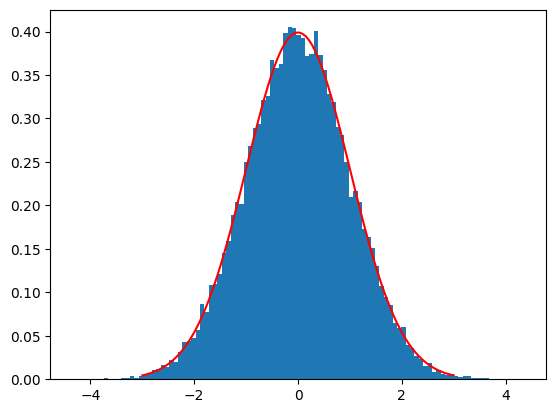

In [9]:
# look at histogram of one component at the last timestep

pos = data_clone.squeeze(1) # remove channel dimension
import scipy.stats as stats
X = np.linspace(-3, 3, 100)
Y = stats.norm.pdf(X, 0, 1)
plt.plot(X, Y, color='red')
plt.hist(pos[:, 0], bins='auto', density=True)
plt.show()

* Still need some work to get to the Monte-Carlo estimation for every possible values of speed.

In [9]:
# clone data, since it will be modified by forward process
M = 1
L = []
lims = 3
T = np.linspace(0, 5, 100)
for t in T:
    # Define the number of bins in each dimension
    num_bins = 100  # You can adjust this value as needed
    tmp = []
    for m in range(M):
        data_clone = GMM2.clone()
        pdmp.forward(data_clone, torch.ones(data_clone.shape)*t)
        data_clone = data_clone.clamp(-lims, lims).squeeze(1).numpy()
        # Compute the 2D histogram
        hist, x_edges, y_edges = np.histogram2d(data_clone[:,0], data_clone[:,1], bins=num_bins, range=[[-lims, lims], [-lims, lims]], density=True)
        tmp.append(hist)
        # 'hist' contains the 2D histogram values
        # 'x_edges' and 'y_edges' are the bin edges in the x and y dimensions, respectively
    tmp = np.array(tmp)
    tmp = tmp.mean(axis = 0)
    L.append(tmp)
L = np.array(L)

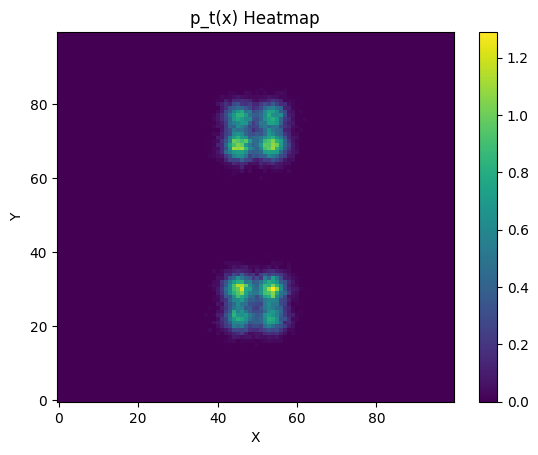

In [11]:
plt.imshow(L[5], origin='lower', aspect='auto')#extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
plt.colorbar()  # Add a color bar to indicate the scale
plt.xlabel('X')  # Label for the x-axis
plt.ylabel('Y')  # Label for the y-axis
plt.title('p_t(x) Heatmap')  # Title of the heatmap
plt.show()  # Display the heatmap

## Train the model

In [3]:
for i in range(0, 1):
    manager.train(nepochs = 20) #progress_epoch=True)
    manager.evaluate()
manager.save('models/model.pt')
manager.save_eval_metrics('models/eval_model.pt')

  2%|██                                                                                                                                    | 3/200 [00:00<00:09, 20.67it/s]

torch.Size([35])
tensor([[[ 4.3080e-01,  3.1063e-01]],

        [[ 3.0305e-01, -8.5781e-01]],

        [[-7.9900e-01,  1.7247e+00]],

        [[-5.3100e-01,  1.7455e-01]],

        [[ 3.9815e-01, -1.4775e+00]],

        [[-4.2183e-01,  2.8123e-01]],

        [[ 1.2218e+00, -2.3771e-01]],

        [[-1.4516e+00, -6.2483e-01]],

        [[ 1.4386e+00, -2.5003e-03]],

        [[ 1.2225e+00, -5.2202e-01]],

        [[-1.0851e+00, -1.4246e+00]],

        [[-2.0965e+00,  7.0703e-01]],

        [[ 3.5252e-01, -1.2127e+00]],

        [[ 1.0772e+00,  2.5916e-01]],

        [[ 1.0593e-01, -4.6542e-01]],

        [[-1.0295e+00, -5.5525e-01]],

        [[-9.9257e-02, -1.0526e+00]],

        [[ 3.1853e-01, -1.3634e+00]],

        [[-1.6307e+00,  4.9074e-01]],

        [[ 3.2208e+00,  6.5672e-01]],

        [[ 1.2026e+00, -5.2078e-01]],

        [[ 7.1240e-01, -9.5881e-01]],

        [[-2.4925e-01,  1.2705e+00]],

        [[-1.5314e+00,  4.2550e-01]],

        [[ 7.5297e-01, -5.2097e-01]],

        

  3%|████                                                                                                                                  | 6/200 [00:00<00:11, 17.08it/s]

torch.Size([44])
tensor([[[ 0.3896,  1.1380]],

        [[-0.0722,  0.8130]],

        [[-1.2748,  1.6152]],

        [[-0.3582,  0.2549]],

        [[ 0.1205, -1.6293]],

        [[-0.6011,  0.0654]],

        [[ 1.4161, -0.8181]],

        [[ 0.1989,  0.7678]],

        [[-1.8383,  1.6296]],

        [[ 1.9927,  0.4124]],

        [[ 0.1104,  1.4242]],

        [[-0.6732, -0.2189]],

        [[ 0.3282,  0.1280]],

        [[ 0.5363, -1.5521]],

        [[-0.6626,  0.2230]],

        [[-1.2592,  0.2531]],

        [[ 1.6612, -0.7072]],

        [[-3.0937,  0.3113]],

        [[ 1.5726,  0.7472]],

        [[-0.2894, -0.0305]],

        [[ 0.5795, -1.0526]],

        [[-1.4491, -0.4296]],

        [[-0.6979,  1.0737]],

        [[-1.1454, -0.0115]],

        [[ 1.1614,  1.1026]],

        [[-0.4567, -0.1029]],

        [[ 0.2794,  0.0548]],

        [[ 0.4551,  0.4644]],

        [[-0.8365, -0.0065]],

        [[ 0.3271,  0.4439]],

        [[ 0.4099, -0.0323]],

        [[-0.5182,  1.

  5%|██████▋                                                                                                                              | 10/200 [00:00<00:11, 16.50it/s]

torch.Size([39])
tensor([[[-1.1161, -1.5175]],

        [[ 0.8720, -0.4610]],

        [[ 2.2409,  0.0723]],

        [[-1.0650,  0.9134]],

        [[-0.0884,  0.9079]],

        [[ 0.4520,  0.2740]],

        [[-0.4287, -0.1120]],

        [[-1.5047,  0.6130]],

        [[ 0.9020, -1.8846]],

        [[ 0.2065, -0.7953]],

        [[ 0.9281,  0.8542]],

        [[-1.0759,  0.9809]],

        [[-0.5598,  1.0352]],

        [[ 1.1487, -0.5502]],

        [[-0.8937, -2.4023]],

        [[ 1.5963,  0.9300]],

        [[ 0.0954,  0.0824]],

        [[ 1.8703, -0.0158]],

        [[ 1.0939, -1.2500]],

        [[ 0.0334, -0.8851]],

        [[ 1.0200,  1.1791]],

        [[-0.3712,  0.2807]],

        [[ 0.5642,  1.1135]],

        [[-0.1107,  0.5022]],

        [[-0.5609,  0.0872]],

        [[ 1.0222,  0.8661]],

        [[ 1.0364,  2.3607]],

        [[ 0.1958,  0.1066]],

        [[-0.9840,  0.3916]],

        [[ 0.4990,  1.3852]],

        [[ 1.9350, -0.2112]],

        [[ 0.4176,  1.

  6%|████████▋                                                                                                                            | 13/200 [00:00<00:11, 16.99it/s]

torch.Size([35])
tensor([[[-1.1082,  0.2434]],

        [[-0.3803,  0.4226]],

        [[ 0.5531,  1.0245]],

        [[ 0.0189, -0.1925]],

        [[-1.2370,  0.3024]],

        [[-1.4909,  0.6318]],

        [[-0.4374,  1.4974]],

        [[ 0.3200,  0.8464]],

        [[-0.7048, -0.6700]],

        [[ 1.8613,  0.1692]],

        [[ 0.7057,  0.4722]],

        [[ 0.7445, -1.9002]],

        [[-1.0408, -0.3459]],

        [[ 0.7500, -0.7339]],

        [[ 0.9762,  0.5479]],

        [[ 1.2482,  2.6125]],

        [[-1.6058,  1.2937]],

        [[ 0.5683,  2.2380]],

        [[ 2.3184,  0.6716]],

        [[ 0.7849,  0.7540]],

        [[ 0.7645,  0.1711]],

        [[ 0.0859,  0.0111]],

        [[ 0.3531, -0.9283]],

        [[-0.5747, -1.0588]],

        [[ 0.8868,  0.7788]],

        [[ 0.5854, -1.1753]],

        [[-1.4132, -0.5457]],

        [[-0.0455,  0.1043]],

        [[-0.5155, -0.4624]],

        [[ 0.8379, -2.3987]],

        [[ 0.7062, -0.2989]],

        [[-0.3407, -1.

  9%|███████████▉                                                                                                                         | 18/200 [00:01<00:10, 18.16it/s]

tensor([[[-1.3338,  0.4311]],

        [[ 1.8816,  2.2279]],

        [[-0.1332,  0.3790]],

        [[-0.1777, -0.1086]],

        [[ 0.3809, -1.4202]],

        [[-1.8302, -0.5388]],

        [[ 0.1687, -0.5300]],

        [[ 0.9903,  0.9590]],

        [[-0.2578, -0.2854]],

        [[-0.7509, -0.9104]],

        [[-1.4906,  0.1885]],

        [[-0.8741, -0.8115]],

        [[ 0.1736, -0.8843]],

        [[-0.8571,  0.7677]],

        [[-0.3651,  1.6609]],

        [[-0.3883,  0.9244]],

        [[ 0.5497, -0.0508]],

        [[-0.4277, -0.4918]],

        [[-1.1904, -1.1796]],

        [[ 0.3470, -0.7549]],

        [[-2.4808, -0.9202]],

        [[-0.3893, -0.6813]],

        [[-0.4368,  0.3766]],

        [[-0.6438,  0.9473]],

        [[ 0.1968,  1.3811]],

        [[-1.3668,  1.2007]],

        [[-0.2046, -0.2542]],

        [[-0.2038,  0.3947]],

        [[-0.1235, -0.4070]],

        [[ 0.5069, -0.1940]],

        [[ 0.2666,  1.0653]],

        [[-0.8641,  0.7022]],

        

 10%|█████████████▎                                                                                                                       | 20/200 [00:01<00:10, 16.78it/s]

tensor([[[-0.2169,  0.1464]],

        [[ 1.1506, -0.6684]],

        [[-0.7767,  0.4797]],

        [[-0.3624, -0.5013]],

        [[ 1.0300,  1.0435]],

        [[ 0.1060, -2.5601]],

        [[ 0.9700,  0.2922]],

        [[ 0.9410,  0.5625]],

        [[ 2.3028,  0.0231]],

        [[-2.5842, -0.2050]],

        [[ 0.3334,  0.3592]],

        [[ 0.7282, -1.1963]],

        [[ 0.5824,  0.2520]],

        [[ 0.0607, -0.5335]],

        [[ 0.0842, -1.0312]],

        [[-0.5467, -0.1716]],

        [[ 0.4665, -1.5014]],

        [[ 0.7198,  0.9743]],

        [[-0.3785,  1.1874]],

        [[-1.1028, -0.5535]],

        [[ 1.2408,  2.0680]],

        [[ 0.6716,  1.2169]],

        [[ 2.4348, -1.9247]],

        [[ 0.5859, -2.7323]],

        [[-0.3414,  1.2189]],

        [[-1.1332, -1.5395]],

        [[ 2.8355, -0.7406]],

        [[ 0.3819,  1.5086]],

        [[-0.9623,  0.3928]],

        [[-1.4206,  1.6105]],

        [[ 1.0398,  1.7195]],

        [[ 0.2912,  1.9851]],

        

 13%|█████████████████▎                                                                                                                   | 26/200 [00:01<00:09, 17.47it/s]

torch.Size([32])
tensor([[[ 0.7224,  1.7147]],

        [[ 1.1090, -0.0492]],

        [[-0.5710, -1.0177]],

        [[-1.4390, -0.2273]],

        [[ 0.4300, -0.5473]],

        [[ 1.2162, -0.5791]],

        [[ 1.4442,  1.6384]],

        [[-0.0741, -2.9721]],

        [[-0.9865, -1.9694]],

        [[-0.2046, -1.3595]],

        [[-1.2001, -0.3584]],

        [[-0.2150,  0.7654]],

        [[ 0.9792,  0.8268]],

        [[ 1.4855,  0.0273]],

        [[-0.3041, -0.8554]],

        [[ 1.0893, -0.5611]],

        [[ 1.9020,  1.1895]],

        [[ 0.6570, -2.1461]],

        [[-0.4672, -0.0301]],

        [[-0.1389,  0.1477]],

        [[-0.0202,  0.7084]],

        [[-0.5187, -0.3527]],

        [[-1.1674,  0.1742]],

        [[ 0.3707, -0.5193]],

        [[ 0.4551, -0.5532]],

        [[ 0.5079, -1.2931]],

        [[-0.3012, -0.9474]],

        [[-0.8693, -0.3495]],

        [[ 0.6505, -0.6624]],

        [[-1.3759,  0.6727]],

        [[-0.1488,  1.5041]],

        [[-1.4421,  0.

 14%|██████████████████▌                                                                                                                  | 28/200 [00:01<00:10, 17.05it/s]

torch.Size([41])
tensor([[[-1.1500,  0.4980]],

        [[ 0.6280, -0.6788]],

        [[-1.1965, -0.0449]],

        [[-1.2321, -0.5279]],

        [[ 1.8628, -0.2597]],

        [[-0.0576, -0.9810]],

        [[ 0.0924,  0.9255]],

        [[-0.6189,  0.9277]],

        [[ 0.6753,  0.0967]],

        [[ 0.4820, -0.6223]],

        [[-1.2026, -0.9118]],

        [[-1.0751,  2.4618]],

        [[-0.6790, -1.4790]],

        [[ 0.4564, -0.0903]],

        [[ 0.3526,  1.3415]],

        [[ 0.2969,  0.3786]],

        [[-1.2287, -0.2420]],

        [[ 0.9630,  0.2288]],

        [[ 1.4680, -0.6756]],

        [[-0.7007, -0.4322]],

        [[-1.1173, -0.0338]],

        [[-0.3492,  0.2491]],

        [[-0.9588,  2.0024]],

        [[-1.4022,  0.5488]],

        [[ 0.3525, -0.0493]],

        [[-1.1084,  0.1618]],

        [[-0.2295, -0.2344]],

        [[-1.3138,  0.3640]],

        [[ 0.0936, -0.0084]],

        [[ 1.1189, -0.5276]],

        [[-1.2774, -0.5195]],

        [[ 0.6726,  1.

 16%|█████████████████████▉                                                                                                               | 33/200 [00:01<00:09, 17.64it/s]

torch.Size([27])
tensor([[[ 0.9053, -0.1244]],

        [[ 3.0258, -1.2037]],

        [[-0.6726, -1.2346]],

        [[-0.0245,  2.1309]],

        [[ 2.4729, -0.5897]],

        [[ 1.1641,  0.6327]],

        [[-1.2228, -0.6836]],

        [[-0.5156,  1.1346]],

        [[ 0.3952,  0.2807]],

        [[-0.8063,  2.3377]],

        [[ 0.5711,  0.1842]],

        [[ 0.4136,  3.2434]],

        [[ 0.4109, -2.0679]],

        [[ 3.0129,  0.6988]],

        [[ 0.7725,  0.4506]],

        [[-0.1082, -0.4970]],

        [[-1.1986, -0.6987]],

        [[ 1.3457, -0.4200]],

        [[-0.0434, -1.1036]],

        [[ 1.6007,  1.0069]],

        [[ 1.0761,  0.4464]],

        [[ 0.2773,  0.9112]],

        [[-0.5610,  0.4474]],

        [[-0.0240,  1.2484]],

        [[-0.2626, -0.4319]],

        [[-0.9407,  1.5771]],

        [[-1.3385,  0.1008]]], device='mps:0')
torch.Size([39])
tensor([[[-1.0227, -1.9811]],

        [[-0.0650, -0.3853]],

        [[-0.9201,  1.7268]],

        [[ 0.3534, -

 18%|███████████████████████▉                                                                                                             | 36/200 [00:02<00:08, 18.83it/s]

torch.Size([37])
tensor([[[-0.1279, -0.8202]],

        [[ 1.1247, -0.6432]],

        [[-0.2549, -0.1386]],

        [[-0.7662, -1.3714]],

        [[-0.8303,  0.7864]],

        [[-1.3761, -1.2685]],

        [[ 0.8281,  0.7350]],

        [[ 0.2125, -0.7571]],

        [[ 0.5968,  0.0898]],

        [[-1.2378,  1.1229]],

        [[ 0.6681, -2.5755]],

        [[-0.2933,  0.9205]],

        [[ 0.8940,  0.2975]],

        [[ 0.3049,  1.1084]],

        [[-0.4315,  0.5425]],

        [[ 0.4174,  2.6889]],

        [[ 0.6173, -0.6504]],

        [[-0.3884, -0.2956]],

        [[-1.2822,  0.8297]],

        [[ 1.0549,  0.1795]],

        [[-1.2028, -0.0343]],

        [[-0.8382,  0.6955]],

        [[-0.9403, -1.1300]],

        [[-2.1485,  0.2006]],

        [[-0.4059,  0.2673]],

        [[-0.1742, -0.1105]],

        [[-1.7679, -0.7953]],

        [[ 1.2367, -0.7671]],

        [[-0.0746,  0.2694]],

        [[-0.7346,  0.6326]],

        [[-0.0110,  0.7168]],

        [[-1.7559, -1.

 21%|███████████████████████████▉                                                                                                         | 42/200 [00:02<00:07, 20.64it/s]

tensor([[[ 6.2306e-01,  1.8335e+00]],

        [[ 5.9203e-01, -1.5929e+00]],

        [[-1.6116e+00, -7.3201e-01]],

        [[ 2.6225e+00, -3.7468e-01]],

        [[-5.2133e-01, -2.9724e-01]],

        [[-6.3577e-01, -6.4619e-01]],

        [[ 9.6021e-01,  1.8252e-01]],

        [[ 1.2042e+00,  1.4932e-01]],

        [[-1.0764e+00,  8.8839e-01]],

        [[ 2.3050e-01, -6.9654e-01]],

        [[ 1.6050e+00,  5.6032e-01]],

        [[-7.0404e-01, -1.1399e-01]],

        [[ 1.3691e+00, -1.1350e+00]],

        [[-1.9755e-01, -1.2688e+00]],

        [[ 1.4622e+00,  1.4022e+00]],

        [[ 7.3041e-01, -3.1256e-01]],

        [[ 9.5901e-01, -8.8039e-01]],

        [[-2.5626e-01, -6.3617e-01]],

        [[ 1.3522e+00, -1.4952e+00]],

        [[ 1.3668e+00,  3.2900e+00]],

        [[-1.2555e+00, -1.0825e-01]],

        [[-1.8333e+00,  5.1594e-01]],

        [[-4.4237e-01,  1.3180e+00]],

        [[ 2.5661e+00, -1.2756e+00]],

        [[-3.3485e-01,  8.1930e-01]],

        [[ 3.8784e-01,  9

 22%|█████████████████████████████▉                                                                                                       | 45/200 [00:02<00:07, 21.10it/s]

torch.Size([30])
tensor([[[-1.0579,  0.7138]],

        [[ 0.9821,  1.1209]],

        [[ 0.0080, -0.3077]],

        [[-0.9817,  2.2116]],

        [[ 0.4651, -0.5631]],

        [[ 1.3834,  0.3925]],

        [[-1.0107,  0.4268]],

        [[ 2.1174,  0.5880]],

        [[ 0.0707,  1.2305]],

        [[-0.2041,  1.1440]],

        [[-0.8527,  0.6348]],

        [[-0.6288, -0.1619]],

        [[-1.7452, -0.5831]],

        [[ 1.0870, -1.6393]],

        [[ 0.3700, -0.0607]],

        [[-0.7801, -0.9291]],

        [[ 0.4495, -0.9767]],

        [[-1.4435, -0.2135]],

        [[-1.2560,  0.8340]],

        [[ 0.5743, -0.4938]],

        [[ 0.6547,  1.7665]],

        [[-0.0609,  0.5674]],

        [[-1.2488,  0.2330]],

        [[ 1.2006,  0.9008]],

        [[ 0.1733,  1.3763]],

        [[-0.1046,  0.0029]],

        [[-0.3760,  1.1737]],

        [[-0.8964,  0.9542]],

        [[ 2.3594,  0.3956]],

        [[ 0.3250,  0.9105]]], device='mps:0')
torch.Size([30])
tensor([[[-0.9162,  

 26%|█████████████████████████████████▉                                                                                                   | 51/200 [00:02<00:07, 20.66it/s]

tensor([[[ 0.6144, -0.1808]],

        [[ 1.2240, -0.7855]],

        [[ 0.8886,  0.5136]],

        [[-0.3887,  0.8502]],

        [[ 1.4066, -0.5175]],

        [[ 0.1088,  1.0434]],

        [[-1.0869,  1.2737]],

        [[-0.8958,  0.7634]],

        [[-0.6515,  0.3952]],

        [[-1.9042, -0.1080]],

        [[-0.1190,  1.1944]],

        [[-0.7418, -1.1125]],

        [[ 0.4949, -1.1319]],

        [[ 0.5191,  0.9960]],

        [[ 0.8340,  0.4296]],

        [[-0.8449, -0.1194]],

        [[ 1.3183,  0.0169]],

        [[ 1.0225, -0.1615]],

        [[-0.1503, -1.3413]],

        [[ 1.1484,  1.0782]],

        [[-0.9729,  1.1597]],

        [[-0.3949, -0.7156]],

        [[ 0.5394,  0.0976]],

        [[-0.5110, -0.2774]],

        [[ 0.9024,  0.7520]],

        [[ 0.2209,  0.5956]],

        [[-1.4243,  0.5806]],

        [[ 2.5917, -0.2281]],

        [[-0.1120,  0.4183]],

        [[-0.0908, -0.1620]],

        [[-0.4780, -1.2330]],

        [[ 0.8554, -0.6007]],

        

 27%|███████████████████████████████████▉                                                                                                 | 54/200 [00:02<00:07, 18.90it/s]

tensor([[[ 1.1525, -0.6591]],

        [[ 0.0900,  0.9940]],

        [[-0.0179,  0.7862]],

        [[-1.7055, -1.7831]],

        [[ 0.2534,  1.6462]],

        [[ 0.2760, -1.3006]],

        [[-1.8584, -0.7136]],

        [[-0.0588,  1.6280]],

        [[-2.0554,  0.3889]],

        [[ 0.8500,  0.3247]],

        [[-1.9923,  1.4552]],

        [[ 1.0950, -0.9240]],

        [[ 1.2284,  2.4991]],

        [[-1.4204,  0.6728]],

        [[-0.1175,  0.2537]],

        [[ 1.1963,  0.1305]]], device='mps:0')
torch.Size([40])
tensor([[[-2.2158, -0.1736]],

        [[-1.5405, -1.8017]],

        [[-0.3472,  0.2973]],

        [[ 0.2394,  2.1359]],

        [[-0.4661,  0.1146]],

        [[ 0.2691, -1.0193]],

        [[-0.1453, -0.6156]],

        [[ 0.9029,  0.7795]],

        [[ 2.0429, -1.6989]],

        [[ 0.0090, -0.9217]],

        [[-1.1151, -0.4507]],

        [[-0.5940, -0.1148]],

        [[-0.5842,  1.0540]],

        [[-0.7610, -0.0909]],

        [[-1.3586,  0.0729]],

      

 30%|███████████████████████████████████████▉                                                                                             | 60/200 [00:03<00:06, 20.69it/s]

tensor([[[ 0.2492, -0.0856]],

        [[ 1.7189, -2.0167]],

        [[ 0.7803,  1.9701]],

        [[ 0.7777,  0.7759]],

        [[-0.8257,  0.8922]],

        [[-1.4180,  0.5875]],

        [[ 0.8226,  0.5157]],

        [[-0.8613, -1.8316]],

        [[ 2.2448,  1.3698]],

        [[ 1.2647,  0.0409]],

        [[ 0.4323,  0.7935]],

        [[ 1.4284,  1.7235]],

        [[ 0.1795,  0.0040]],

        [[-1.5718,  0.3101]],

        [[ 1.7410,  0.4181]],

        [[-1.8358,  0.4972]],

        [[ 0.5457,  0.6812]],

        [[ 0.4522, -0.9025]],

        [[-0.1440,  0.5733]],

        [[-0.9435, -1.1937]],

        [[ 1.3594, -0.4418]],

        [[ 1.2202, -0.9165]],

        [[-0.5620, -0.9719]],

        [[ 1.1627, -0.7708]],

        [[-1.3013,  0.6715]],

        [[-0.4007,  0.0899]],

        [[-0.6699, -0.1063]],

        [[ 1.1811,  0.4214]],

        [[ 0.8487, -1.0079]],

        [[-0.7108, -0.2463]],

        [[ 1.7659, -0.1183]]], device='mps:0')
torch.Size([32])
tensor

 32%|█████████████████████████████████████████▉                                                                                           | 63/200 [00:03<00:06, 20.11it/s]

torch.Size([33])
tensor([[[ 0.2388,  1.6986]],

        [[-0.3916, -0.2337]],

        [[ 0.0631, -1.0416]],

        [[ 0.7877, -0.1724]],

        [[-0.6372,  1.3611]],

        [[ 1.8752, -0.2920]],

        [[ 1.4857, -1.5936]],

        [[-1.6955,  0.2293]],

        [[ 0.3397,  1.6717]],

        [[ 0.7330, -1.3038]],

        [[ 0.1533,  0.8395]],

        [[ 1.0543, -0.3901]],

        [[-1.1927,  0.2982]],

        [[-0.2789, -0.9222]],

        [[ 0.6855, -1.3669]],

        [[-1.3150, -0.4195]],

        [[-0.2019, -0.5333]],

        [[-0.3563, -1.4629]],

        [[ 2.2212,  1.5537]],

        [[-0.7157,  0.5108]],

        [[-0.4541, -0.4223]],

        [[-0.8945, -0.1328]],

        [[-1.0000,  0.7654]],

        [[-0.9532, -0.4928]],

        [[-0.2502, -0.2542]],

        [[ 0.2573,  1.3164]],

        [[-2.1581, -0.7061]],

        [[ 0.5420,  1.0554]],

        [[-0.8730, -1.9406]],

        [[-0.2249, -0.4952]],

        [[ 1.0788,  0.1497]],

        [[-0.1194, -0.

 33%|███████████████████████████████████████████▉                                                                                         | 66/200 [00:03<00:06, 19.81it/s]

torch.Size([25])
tensor([[[ 0.5325,  0.0825]],

        [[-0.1870,  1.0862]],

        [[ 1.2497,  0.0271]],

        [[ 1.7429, -1.6362]],

        [[-0.8366,  0.4056]],

        [[ 0.0798, -0.0645]],

        [[-1.0989, -0.3452]],

        [[-0.6986, -0.1090]],

        [[-0.6561, -0.9517]],

        [[ 0.7762, -0.8851]],

        [[-0.5154, -0.2806]],

        [[ 0.8974, -0.3167]],

        [[-0.8018,  0.8331]],

        [[-0.1014,  0.5429]],

        [[ 0.6075,  1.9595]],

        [[-0.8748,  1.0568]],

        [[-1.1716, -0.7422]],

        [[ 0.2758,  0.4474]],

        [[-0.5945,  1.3658]],

        [[-0.0821,  0.2570]],

        [[ 1.1404,  0.1999]],

        [[ 0.0539,  2.8380]],

        [[-1.2977,  0.1698]],

        [[ 0.3349, -0.8211]],

        [[ 0.5524,  1.9669]]], device='mps:0')
torch.Size([24])
tensor([[[-0.1173,  0.1703]],

        [[-0.6034, -2.0106]],

        [[ 1.6850, -0.3082]],

        [[-0.6459, -1.0397]],

        [[ 0.4310,  0.3415]],

        [[-0.5068, -

 36%|███████████████████████████████████████████████▉                                                                                     | 72/200 [00:03<00:06, 20.34it/s]

torch.Size([22])
tensor([[[ 1.7890, -0.1291]],

        [[-2.2035,  0.4662]],

        [[-0.0101,  0.8940]],

        [[ 0.4058,  0.7116]],

        [[-1.2253,  0.4236]],

        [[ 1.6801, -1.5052]],

        [[-0.7204, -0.1624]],

        [[-1.3560,  2.4129]],

        [[ 1.0834,  0.6214]],

        [[-1.5216, -0.4897]],

        [[ 0.4100, -2.1228]],

        [[ 0.0619,  0.1386]],

        [[ 0.5119, -0.6921]],

        [[ 1.6789,  0.0857]],

        [[ 1.3841, -1.2875]],

        [[-0.4464,  0.2881]],

        [[-0.1393,  0.1444]],

        [[ 0.3297, -0.8769]],

        [[-0.8787, -0.4851]],

        [[-0.1027,  0.0295]],

        [[-0.4044,  0.8886]],

        [[-0.7679, -0.9404]]], device='mps:0')
torch.Size([26])
tensor([[[ 0.3766, -0.1196]],

        [[ 0.3034, -0.7914]],

        [[-0.0251, -0.3106]],

        [[-0.0482,  0.1046]],

        [[ 0.6002,  0.1816]],

        [[-0.5792, -1.3830]],

        [[-1.1434, -0.1861]],

        [[-0.6410, -0.2599]],

        [[-1.4924, -

 38%|█████████████████████████████████████████████████▉                                                                                   | 75/200 [00:03<00:06, 20.55it/s]

torch.Size([28])
tensor([[[-1.8500,  1.8677]],

        [[-0.0872,  0.8932]],

        [[ 0.9354, -0.5949]],

        [[-0.5883, -0.0387]],

        [[ 0.2345,  0.4418]],

        [[ 1.1695, -0.8559]],

        [[ 1.6833,  0.7336]],

        [[-0.2428,  0.2703]],

        [[ 1.7284, -0.0607]],

        [[ 0.8070,  0.0186]],

        [[ 1.3207, -2.4228]],

        [[ 0.3916,  0.1327]],

        [[-1.2869, -0.4636]],

        [[ 0.0105, -1.5732]],

        [[-0.1703,  0.2237]],

        [[ 0.7706,  1.0060]],

        [[-0.5158,  0.1884]],

        [[-0.2941, -0.3236]],

        [[ 1.0595, -0.7579]],

        [[-1.2655, -0.3440]],

        [[-0.5537,  2.2548]],

        [[ 0.3522, -0.5894]],

        [[ 1.0840, -1.1596]],

        [[-1.1622, -0.1895]],

        [[ 0.3514, -0.8854]],

        [[ 1.5385,  1.0463]],

        [[-0.8177, -1.5981]],

        [[-1.8656, -0.3201]]], device='mps:0')
torch.Size([26])
tensor([[[ 0.9826,  0.6376]],

        [[-1.0163, -0.6837]],

        [[-1.3160,  

 40%|█████████████████████████████████████████████████████▊                                                                               | 81/200 [00:04<00:05, 20.91it/s]

torch.Size([26])
tensor([[[ 0.9807,  0.0079]],

        [[ 1.7453,  0.4330]],

        [[-0.4536, -2.2856]],

        [[-1.6923,  1.3557]],

        [[ 1.3462,  0.5448]],

        [[-1.2671, -0.9987]],

        [[ 0.3406, -0.4605]],

        [[ 1.1297,  0.4301]],

        [[ 1.4847, -0.2744]],

        [[-0.8867, -0.9295]],

        [[ 0.3758, -0.4273]],

        [[-0.8734,  1.2994]],

        [[ 0.9428,  0.3816]],

        [[-0.8980,  1.1570]],

        [[ 0.2007,  0.1579]],

        [[ 1.6576, -0.4233]],

        [[-0.6049, -0.9574]],

        [[ 0.5923,  0.0136]],

        [[-1.5397, -0.6548]],

        [[ 0.0571,  0.9782]],

        [[ 1.2453, -0.6197]],

        [[ 1.8312, -0.9404]],

        [[-0.4068,  0.2817]],

        [[ 0.0136,  0.5325]],

        [[-0.1347,  0.4423]],

        [[-0.2275, -0.1665]]], device='mps:0')
torch.Size([20])
tensor([[[-0.0646,  0.2940]],

        [[-0.6341,  0.9259]],

        [[ 0.9905,  0.7607]],

        [[ 1.0987, -0.1339]],

        [[-1.0472, -

 42%|███████████████████████████████████████████████████████▊                                                                             | 84/200 [00:04<00:05, 21.11it/s]

torch.Size([27])
tensor([[[-2.8037e-01,  5.2080e-01]],

        [[ 2.3085e+00,  1.8279e-01]],

        [[ 9.4562e-01, -1.5348e-01]],

        [[-3.8258e-02,  9.2401e-01]],

        [[-2.2355e-01,  2.6797e-01]],

        [[-1.3030e-02, -2.1423e+00]],

        [[ 1.4627e+00,  1.2839e+00]],

        [[ 4.4076e-01, -6.9159e-01]],

        [[-4.3566e-01, -1.5162e-02]],

        [[ 1.8676e+00, -1.0846e+00]],

        [[-1.5048e+00,  1.9842e-01]],

        [[ 1.1615e-03,  2.2422e-01]],

        [[-4.0620e-01,  9.1853e-01]],

        [[-7.3211e-01, -1.1560e-01]],

        [[ 3.6074e-03,  1.6341e+00]],

        [[ 1.2525e-01, -8.1519e-02]],

        [[ 6.0846e-01, -1.7230e+00]],

        [[ 1.2419e+00,  1.2797e-02]],

        [[ 1.5966e+00, -5.5397e-02]],

        [[ 1.0016e+00, -1.5623e+00]],

        [[ 1.2860e+00, -1.1366e+00]],

        [[ 1.1855e+00,  2.2981e-01]],

        [[-1.3151e+00,  1.3808e-01]],

        [[ 3.3507e-01, -2.2690e+00]],

        [[-1.3962e+00,  3.8545e-01]],

        

 45%|███████████████████████████████████████████████████████████▊                                                                         | 90/200 [00:04<00:05, 21.01it/s]

tensor([[[-1.6495,  0.7953]],

        [[ 0.0497,  0.2884]],

        [[ 1.2149,  0.4598]],

        [[ 1.0158, -0.0300]],

        [[ 1.0453,  0.5146]],

        [[ 1.3504,  0.4713]],

        [[-1.0254,  0.4829]],

        [[-0.5364,  0.0905]],

        [[-0.0048,  0.1706]],

        [[ 0.5734, -0.8531]],

        [[ 0.1680,  0.2696]],

        [[ 1.7855, -0.2833]],

        [[-0.1106,  1.0074]],

        [[ 0.2569, -0.3826]],

        [[ 0.7364,  2.0887]],

        [[-0.3960,  1.3182]],

        [[-0.4067,  0.8623]],

        [[ 0.3322,  0.0084]],

        [[ 1.6358, -0.9356]],

        [[ 2.2999, -0.5561]],

        [[ 0.6635, -1.8882]],

        [[-0.7747, -0.0355]],

        [[-0.5288,  0.0788]],

        [[-1.6018, -0.8113]],

        [[-0.2821, -0.4811]],

        [[ 0.3240,  0.6046]],

        [[ 0.0619, -0.4277]]], device='mps:0')
torch.Size([25])
tensor([[[ 0.7891,  0.7095]],

        [[ 0.2296, -2.3296]],

        [[ 1.6623, -0.6357]],

        [[-0.6725, -0.3723]],

      

 48%|███████████████████████████████████████████████████████████████▊                                                                     | 96/200 [00:04<00:04, 21.69it/s]

torch.Size([26])
tensor([[[-0.9791,  0.3029]],

        [[ 1.4338, -0.1901]],

        [[-0.6414, -0.2007]],

        [[-0.3223,  0.2791]],

        [[ 1.1638, -0.0538]],

        [[ 1.4652, -0.4415]],

        [[-1.8655, -1.0776]],

        [[-0.4224,  0.0534]],

        [[-1.0921,  0.4407]],

        [[ 0.4118,  0.0954]],

        [[-1.1179, -1.0082]],

        [[ 0.5780,  0.1014]],

        [[ 0.0260, -0.2662]],

        [[ 0.6643, -1.4134]],

        [[-1.5203,  1.1929]],

        [[-1.0470,  0.9207]],

        [[-1.4182,  0.0816]],

        [[-1.0242,  1.4340]],

        [[ 0.1401,  0.3844]],

        [[ 0.7434, -0.6793]],

        [[ 0.1647,  1.9054]],

        [[ 1.0176, -1.3356]],

        [[-0.5388, -0.6892]],

        [[-1.4632, -0.9364]],

        [[ 0.3348, -0.0891]],

        [[ 1.0184, -0.4073]]], device='mps:0')
torch.Size([24])
tensor([[[ 1.4721e+00, -4.4319e-01]],

        [[-1.0103e+00, -1.7325e-01]],

        [[ 2.4401e+00,  1.3508e+00]],

        [[-1.7236e-01,  2.3

 50%|█████████████████████████████████████████████████████████████████▊                                                                   | 99/200 [00:05<00:04, 21.25it/s]

torch.Size([13])
tensor([[[-0.8615, -0.6767]],

        [[ 0.5631, -0.4378]],

        [[ 1.2360,  0.2394]],

        [[-1.0288,  2.2037]],

        [[-0.8829, -0.1627]],

        [[-0.9528,  0.6369]],

        [[ 3.0165, -0.2948]],

        [[ 0.6731, -1.1615]],

        [[ 1.3498, -0.2484]],

        [[ 1.2362, -0.0669]],

        [[ 1.1638, -0.7670]],

        [[ 0.9403, -0.0122]],

        [[-0.3968, -0.3287]]], device='mps:0')
torch.Size([19])
tensor([[[-0.5350, -0.6168]],

        [[ 0.3837, -0.2376]],

        [[-0.4397, -0.1781]],

        [[ 1.7165,  0.1328]],

        [[ 1.5361, -1.1485]],

        [[ 0.0210, -0.7952]],

        [[-0.9074, -1.1385]],

        [[ 1.9228, -1.1442]],

        [[-0.4752,  0.0521]],

        [[ 0.7005, -0.0855]],

        [[-1.7314,  0.1546]],

        [[-1.4756, -1.1944]],

        [[-1.0897,  0.8620]],

        [[ 1.9514,  0.5751]],

        [[-0.9406,  1.6045]],

        [[-0.2165,  1.4431]],

        [[-0.3015,  1.2744]],

        [[ 1.7184,  

 52%|█████████████████████████████████████████████████████████████████████▎                                                              | 105/200 [00:05<00:04, 21.30it/s]

torch.Size([31])
tensor([[[-0.1511, -2.0556]],

        [[ 0.4838,  0.7516]],

        [[-1.2364,  1.0663]],

        [[ 1.3639,  0.0048]],

        [[ 1.2393, -0.2868]],

        [[ 1.4802, -0.1153]],

        [[ 1.6512, -1.3040]],

        [[-0.2403, -1.5790]],

        [[ 0.2538, -0.1172]],

        [[ 1.1186, -0.1234]],

        [[-1.0194, -0.2855]],

        [[-0.5149,  0.2344]],

        [[-0.3205,  0.2221]],

        [[-0.0647, -0.5414]],

        [[ 1.2157, -0.1392]],

        [[ 1.6276, -1.4937]],

        [[-1.8028, -0.3609]],

        [[-0.4706, -0.2888]],

        [[-1.2967,  0.0742]],

        [[ 0.5678, -0.9140]],

        [[ 0.1991, -0.8237]],

        [[-1.4364, -0.3190]],

        [[ 0.7180, -0.6649]],

        [[ 0.9333, -0.6229]],

        [[-0.8913,  0.9107]],

        [[ 0.0359, -0.2412]],

        [[ 0.5206, -0.3257]],

        [[ 0.6913, -0.4373]],

        [[-1.2543, -0.4652]],

        [[ 0.6956,  0.7426]],

        [[-1.6355,  1.3558]]], device='mps:0')
torch.

 54%|███████████████████████████████████████████████████████████████████████▎                                                            | 108/200 [00:05<00:04, 21.97it/s]

torch.Size([27])
tensor([[[ 0.8034, -0.0243]],

        [[ 0.6787,  1.2235]],

        [[-1.2534,  0.1089]],

        [[ 0.1701, -1.6653]],

        [[-0.5306, -1.2071]],

        [[-0.5909,  0.4477]],

        [[ 0.2170,  0.7975]],

        [[-1.0632, -0.0981]],

        [[ 0.6910, -1.3290]],

        [[ 0.0721,  0.3831]],

        [[ 0.7023,  1.4912]],

        [[-0.7840,  0.1282]],

        [[-1.2508, -0.4291]],

        [[-0.5347, -0.1025]],

        [[ 0.8141,  0.1063]],

        [[ 1.5261, -1.0204]],

        [[-1.6295, -0.2209]],

        [[-1.4837,  0.0309]],

        [[ 1.9177, -0.9840]],

        [[-1.8473,  0.6864]],

        [[-0.5519, -0.0281]],

        [[ 1.8682, -0.5599]],

        [[-1.1029,  1.0201]],

        [[ 1.0580, -0.4637]],

        [[-0.1998,  0.4374]],

        [[ 2.2668,  0.6845]],

        [[-0.3318,  0.1286]]], device='mps:0')
torch.Size([21])
tensor([[[-0.9966,  0.9744]],

        [[-0.9470, -0.4733]],

        [[-1.1344,  0.8202]],

        [[ 1.8761,  

 57%|███████████████████████████████████████████████████████████████████████████▏                                                        | 114/200 [00:05<00:04, 20.77it/s]

torch.Size([22])
tensor([[[-1.8804,  1.2245]],

        [[ 2.1288, -0.2870]],

        [[-0.6413,  0.1032]],

        [[-0.6813, -0.1912]],

        [[-0.9157, -0.7696]],

        [[ 1.7051,  0.1962]],

        [[ 1.7900,  0.3884]],

        [[ 0.9348,  0.5155]],

        [[ 0.8557, -0.0297]],

        [[ 0.3350,  0.0995]],

        [[-0.9706,  0.6782]],

        [[-1.1452, -0.5801]],

        [[ 1.3010, -0.0776]],

        [[ 0.3232, -1.5026]],

        [[-1.3119,  1.0007]],

        [[ 0.5443,  1.3661]],

        [[ 1.2769, -0.9017]],

        [[ 1.4271,  0.3572]],

        [[ 1.5007,  0.3338]],

        [[-1.1952,  0.8399]],

        [[ 0.1433, -0.9333]],

        [[ 0.2592,  0.3924]]], device='mps:0')
torch.Size([33])
tensor([[[ 1.1699, -1.2085]],

        [[-1.5681, -0.3668]],

        [[ 1.2552,  0.3408]],

        [[ 0.5057,  0.3007]],

        [[-2.4782,  0.8785]],

        [[ 1.2078, -0.1421]],

        [[-1.3958, -0.2021]],

        [[-1.7501, -0.4238]],

        [[ 0.5234, -

 58%|█████████████████████████████████████████████████████████████████████████████▏                                                      | 117/200 [00:05<00:04, 19.99it/s]

torch.Size([18])
tensor([[[-0.0677,  0.6262]],

        [[ 0.0201, -1.1709]],

        [[-0.1073, -0.4604]],

        [[-1.4936, -1.3943]],

        [[-0.9766, -0.7649]],

        [[-0.0610, -0.0595]],

        [[ 1.1707, -0.3292]],

        [[-1.8393,  1.2127]],

        [[ 0.2839,  0.4702]],

        [[-0.7491,  0.5319]],

        [[-0.8468, -0.1023]],

        [[ 1.2598, -0.1124]],

        [[-1.2935,  0.3435]],

        [[ 0.2020, -0.9852]],

        [[ 0.8047,  0.9814]],

        [[-0.3973, -1.1384]],

        [[-0.4633, -0.3630]],

        [[-1.5860,  0.1741]]], device='mps:0')
torch.Size([24])
tensor([[[ 1.7449, -0.3725]],

        [[-1.0708, -0.3714]],

        [[-1.5354,  0.3411]],

        [[ 0.4983,  0.2191]],

        [[-1.1837,  0.0307]],

        [[ 1.3726, -0.2761]],

        [[ 1.0130,  0.4588]],

        [[ 0.9407,  0.3542]],

        [[-1.0883, -1.1955]],

        [[-2.3144, -0.0330]],

        [[-0.4797,  0.4400]],

        [[-0.0530, -0.1803]],

        [[ 0.4234,  

 60%|███████████████████████████████████████████████████████████████████████████████▏                                                    | 120/200 [00:06<00:03, 20.45it/s]

torch.Size([24])
tensor([[[ 0.7300,  0.4390]],

        [[ 1.1670,  0.1683]],

        [[ 0.2386,  0.0335]],

        [[-0.4503, -1.1260]],

        [[-1.2923,  0.5566]],

        [[-1.1266,  1.0477]],

        [[-1.2662, -0.2950]],

        [[ 1.5704, -0.7781]],

        [[ 1.9692,  0.0764]],

        [[-0.2722,  0.0816]],

        [[-0.8083,  0.5030]],

        [[ 0.7102, -0.5926]],

        [[-0.0680,  0.1857]],

        [[-1.3847,  0.0117]],

        [[ 0.2129,  0.0805]],

        [[-0.7387,  0.3824]],

        [[-0.0672, -0.5080]],

        [[ 0.7983,  0.1399]],

        [[-0.7953, -0.1067]],

        [[-0.9825,  0.3887]],

        [[-1.5272, -0.0393]],

        [[ 2.1854, -0.1685]],

        [[ 1.0559,  0.7557]],

        [[-1.5613,  0.1521]]], device='mps:0')
torch.Size([36])
tensor([[[-0.9849, -0.5315]],

        [[ 0.8165,  0.0422]],

        [[ 0.7282,  0.3264]],

        [[-2.0904, -0.6624]],

        [[ 0.9369,  1.7331]],

        [[-1.5006, -0.2408]],

        [[ 0.6640, -

 63%|███████████████████████████████████████████████████████████████████████████████████▏                                                | 126/200 [00:06<00:03, 20.06it/s]

tensor([[[ 0.7550,  0.0229]],

        [[ 1.8281,  0.0479]],

        [[-0.1361, -1.8132]],

        [[ 1.8013, -0.0763]],

        [[-0.0339,  0.3560]],

        [[ 0.4185, -3.1403]],

        [[-0.7452, -1.2029]],

        [[ 1.4894, -0.1833]],

        [[ 0.1648, -1.5970]],

        [[-1.7587,  0.2037]],

        [[-0.0973, -0.0433]],

        [[ 1.3768,  0.8105]],

        [[-0.9919,  0.1237]],

        [[ 0.3839, -1.9597]],

        [[ 0.6717,  0.0109]],

        [[-1.2071,  0.3286]],

        [[-0.7703,  0.7421]],

        [[ 0.3980, -1.6162]],

        [[-2.1985, -1.7874]],

        [[-0.8643, -0.3824]],

        [[ 0.2804,  0.8628]],

        [[ 0.7499, -0.4905]],

        [[ 0.8252, -0.5256]],

        [[-1.2224, -0.2376]],

        [[-1.2562, -0.6287]],

        [[-0.1658,  0.0307]],

        [[-0.3849, -3.0893]],

        [[-1.7445,  0.1887]],

        [[ 0.9271,  0.8314]],

        [[-0.6341, -0.7760]],

        [[-0.0374,  0.3831]],

        [[-2.2318, -0.4952]],

        

 64%|█████████████████████████████████████████████████████████████████████████████████████▏                                              | 129/200 [00:06<00:04, 17.33it/s]

torch.Size([51])
tensor([[[ 1.6533,  0.4157]],

        [[-2.1216,  0.8526]],

        [[-2.0715,  1.2443]],

        [[ 0.7677, -0.1816]],

        [[ 0.4284,  1.0085]],

        [[-0.6452,  1.6886]],

        [[-0.7763, -1.0920]],

        [[-1.3276,  0.4088]],

        [[ 1.1059, -1.0674]],

        [[ 1.0307,  0.4457]],

        [[-1.4163,  0.4830]],

        [[ 1.8217, -0.5169]],

        [[-0.9779, -0.4468]],

        [[-1.5463,  1.2598]],

        [[ 0.1363,  0.1136]],

        [[-1.4590,  0.9502]],

        [[-1.8240,  0.6560]],

        [[-1.5857, -0.8999]],

        [[-0.0345,  0.5985]],

        [[ 2.6071,  0.0027]],

        [[ 0.5113, -0.6731]],

        [[ 1.4029, -0.1563]],

        [[-0.9425, -0.7323]],

        [[-1.3750, -0.6228]],

        [[-0.0602,  0.7228]],

        [[-1.5729,  0.1338]],

        [[ 1.5722, -0.2308]],

        [[-1.6346, -0.0507]],

        [[-0.1766,  0.5225]],

        [[ 0.0158,  0.0029]],

        [[-1.2010,  1.3925]],

        [[ 0.1790, -0.

 66%|██████████████████████████████████████████████████████████████████████████████████████▍                                             | 131/200 [00:06<00:04, 15.81it/s]

tensor([[[-0.5558,  1.6127]],

        [[ 0.7168,  0.2905]],

        [[-0.0718,  0.2418]],

        [[ 1.5898, -1.0231]],

        [[-0.4601, -0.6418]],

        [[ 0.6128,  0.7468]],

        [[ 1.8632, -0.9172]],

        [[ 0.7891,  2.8650]],

        [[ 1.4257, -0.7609]],

        [[-0.3531,  0.3072]],

        [[-1.4792, -0.0849]],

        [[ 1.3581, -1.7551]],

        [[ 0.1206, -0.7259]],

        [[ 0.6114,  0.5218]],

        [[-0.5166,  0.7879]],

        [[-0.2998,  0.5962]],

        [[-1.3761,  0.0643]],

        [[-0.5188, -0.2297]],

        [[-1.6668, -0.6788]],

        [[-1.1537,  0.6931]],

        [[-0.0484, -0.5839]],

        [[-0.6502,  1.4522]],

        [[ 0.6517, -0.1706]],

        [[ 1.4386, -0.9672]],

        [[-1.4755, -0.4299]],

        [[ 0.5208,  0.9217]],

        [[ 0.0199, -0.6229]],

        [[-1.1295,  0.8842]],

        [[-1.5845, -0.1087]],

        [[-0.1900,  0.6221]],

        [[ 2.1936,  0.3244]],

        [[-1.5906, -1.2316]],

        

 66%|███████████████████████████████████████████████████████████████████████████████████████▊                                            | 133/200 [00:06<00:04, 14.86it/s]

torch.Size([70])
tensor([[[-1.4800,  1.8714]],

        [[-0.3564,  0.3984]],

        [[ 0.3326,  1.1501]],

        [[ 2.0273, -0.7224]],

        [[-0.7933, -0.4318]],

        [[-1.6351,  1.4856]],

        [[ 0.4329,  0.5342]],

        [[ 1.4049,  1.2053]],

        [[-0.5099, -0.2480]],

        [[ 1.4752,  0.7166]],

        [[ 2.3223, -0.8107]],

        [[-1.6171, -0.4378]],

        [[-1.3149,  2.2448]],

        [[ 1.5796,  1.7510]],

        [[-2.3196,  0.5725]],

        [[ 1.8154, -0.4727]],

        [[ 1.7799,  1.1943]],

        [[ 1.6785,  0.1559]],

        [[ 1.7072, -0.1617]],

        [[ 1.9197,  0.9630]],

        [[-2.2992,  0.5152]],

        [[ 1.3906,  1.0231]],

        [[-1.6432, -0.7857]],

        [[ 0.3624,  2.2417]],

        [[-0.3658,  0.1679]],

        [[ 1.0708, -1.5346]],

        [[-0.8318, -0.0337]],

        [[ 0.5538, -0.0765]],

        [[-2.3971,  1.5470]],

        [[ 1.2362, -1.0418]],

        [[-0.1757, -0.3760]],

        [[-1.7845, -0.

 68%|██████████████████████████████████████████████████████████████████████████████████████████▍                                         | 137/200 [00:07<00:04, 12.61it/s]

tensor([[[ 0.0100,  1.1633]],

        [[ 0.8731,  0.7645]],

        [[-1.1947,  1.4466]],

        [[ 0.9545,  1.1796]],

        [[ 1.0690,  1.7066]],

        [[ 0.7913,  0.3024]],

        [[-1.5770,  0.1437]],

        [[-0.6059, -1.1753]],

        [[ 0.6973,  1.6238]],

        [[ 1.3631,  2.5086]],

        [[ 1.1489, -0.0484]],

        [[-0.3027,  2.0931]],

        [[ 0.2825,  2.8195]],

        [[ 2.1660,  0.9523]],

        [[-1.1462,  0.2258]],

        [[-0.1421,  1.9970]],

        [[ 0.7803,  1.4367]],

        [[ 0.3184, -1.3455]],

        [[ 1.8842,  0.7935]],

        [[-2.1581,  0.0516]],

        [[-1.1710,  0.7176]],

        [[ 1.6304, -0.2511]],

        [[ 0.5106,  1.5618]],

        [[-0.5154,  0.2985]],

        [[-1.5640,  0.9622]],

        [[-0.4549, -0.8526]],

        [[-1.1748,  0.2830]],

        [[-1.6239, -1.4681]],

        [[-1.2478, -1.1738]],

        [[-0.5002, -0.9453]],

        [[-0.1635, -0.9002]],

        [[-0.7112,  0.7345]],

        

 70%|███████████████████████████████████████████████████████████████████████████████████████████▋                                        | 139/200 [00:07<00:05, 11.75it/s]

torch.Size([87])
tensor([[[ 1.2378,  1.7605]],

        [[ 1.6293,  0.9095]],

        [[ 2.8806,  0.0918]],

        [[-1.9105, -1.4832]],

        [[-0.8500, -0.9770]],

        [[-0.4192, -0.2908]],

        [[-2.1493, -0.3555]],

        [[-0.4574,  2.0975]],

        [[-1.3842, -1.3669]],

        [[ 0.1347,  0.9884]],

        [[ 1.8965,  0.1763]],

        [[-1.9002, -0.5150]],

        [[ 0.7336,  2.3147]],

        [[ 1.3834,  0.1354]],

        [[ 0.7124,  1.4655]],

        [[ 1.9059, -1.4065]],

        [[ 1.0746,  0.2563]],

        [[ 0.1005,  0.0099]],

        [[ 1.6104, -0.2796]],

        [[ 1.8326,  0.6546]],

        [[ 1.7612,  1.6939]],

        [[-2.0069,  0.1466]],

        [[-1.7926,  2.0274]],

        [[ 1.3207,  0.1115]],

        [[-1.1699, -1.8696]],

        [[-0.5533, -0.0340]],

        [[-1.1466,  0.2399]],

        [[-0.9402, -1.5648]],

        [[-1.3597,  0.4591]],

        [[-1.2356,  1.3320]],

        [[ 0.3515, -1.9214]],

        [[ 2.0102,  0.

 70%|█████████████████████████████████████████████████████████████████████████████████████████████                                       | 141/200 [00:07<00:05, 11.01it/s]

torch.Size([85])
tensor([[[ 3.8472e-01,  1.6684e+00]],

        [[-2.0132e+00,  1.3256e+00]],

        [[ 1.0344e+00,  1.5755e+00]],

        [[ 1.8597e+00, -3.1111e-01]],

        [[ 1.1101e-01,  8.8555e-02]],

        [[-1.0144e+00, -4.1121e-01]],

        [[ 6.5345e-01,  9.8832e-01]],

        [[ 3.1292e-01,  1.1537e+00]],

        [[-1.7753e+00,  1.0963e+00]],

        [[-2.2144e-03,  4.2425e-01]],

        [[ 3.6910e-01,  1.1182e+00]],

        [[ 4.8451e-01,  1.5983e+00]],

        [[ 1.8962e+00, -4.7041e-01]],

        [[-1.6271e+00,  8.1709e-01]],

        [[ 1.4218e+00,  1.7258e+00]],

        [[ 6.6497e-01,  1.2703e+00]],

        [[ 5.7994e-01,  6.5421e-01]],

        [[ 1.6246e+00, -1.1964e+00]],

        [[-1.9616e+00,  1.1891e+00]],

        [[ 1.6403e+00,  1.3617e-01]],

        [[ 7.1842e-01,  7.6049e-02]],

        [[-1.6497e+00,  2.7792e-02]],

        [[-1.6647e+00,  1.8554e+00]],

        [[ 1.5022e+00, -6.4041e-01]],

        [[-2.4070e-01,  7.7538e-01]],

        

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 143/200 [00:07<00:05, 10.45it/s]

torch.Size([110])
tensor([[[ 1.0915,  1.7851]],

        [[ 1.0838,  2.5714]],

        [[ 0.6469,  0.9580]],

        [[-0.7161,  0.4910]],

        [[-2.2821,  0.1562]],

        [[ 0.2980,  0.9425]],

        [[ 0.7761, -1.1098]],

        [[-2.2175, -0.1102]],

        [[ 1.7103,  1.9283]],

        [[ 1.8638,  0.4589]],

        [[ 0.6345,  0.3451]],

        [[ 0.6015,  1.3372]],

        [[-1.6872,  1.7815]],

        [[ 1.2910, -1.0294]],

        [[-3.2821,  2.0468]],

        [[-0.4049,  0.2204]],

        [[-1.6372,  2.0708]],

        [[ 2.1221, -0.7413]],

        [[-0.0668, -0.6474]],

        [[-1.8334,  1.5794]],

        [[ 2.0363,  1.9706]],

        [[-1.8001, -2.1195]],

        [[-0.3017,  2.2372]],

        [[-1.6802,  1.5597]],

        [[-2.3514,  1.4570]],

        [[-0.4741,  1.2275]],

        [[ 0.5153, -0.0081]],

        [[-1.5710,  1.4916]],

        [[-0.8964,  0.6852]],

        [[-1.7783, -0.1413]],

        [[ 0.3409,  0.4562]],

        [[-0.7479,  1

 72%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 145/200 [00:08<00:05,  9.79it/s]

tensor([[[ 2.6255,  1.9225]],

        [[ 1.2271,  1.9613]],

        [[ 1.0565,  0.9608]],

        [[ 1.7103, -1.1159]],

        [[-1.1801, -0.9931]],

        [[-2.1498, -1.1497]],

        [[-0.8704, -1.7453]],

        [[-1.5265,  0.9292]],

        [[ 1.4943, -1.5576]],

        [[ 0.0145,  1.9438]],

        [[ 0.8332,  1.1981]],

        [[ 1.2814,  0.6545]],

        [[ 1.7500, -0.7871]],

        [[-0.0411, -1.0866]],

        [[ 2.0755, -1.3041]],

        [[ 2.2400, -0.3542]],

        [[-0.1194,  2.7628]],

        [[ 1.3962, -1.4469]],

        [[-1.2638, -1.5697]],

        [[ 1.7067, -1.3702]],

        [[ 0.4060,  1.2516]],

        [[ 0.0179,  1.9011]],

        [[-0.1620, -0.1586]],

        [[ 1.8885, -1.4839]],

        [[ 1.9759, -1.4801]],

        [[ 1.8784,  1.4135]],

        [[-0.1906,  1.2657]],

        [[-2.1816, -0.2792]],

        [[-1.2848,  1.2501]],

        [[-2.5781,  2.3647]],

        [[-0.9446,  0.6802]],

        [[ 1.1190,  0.6961]],

        

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 148/200 [00:08<00:05,  9.07it/s]

tensor([[[-2.1747,  1.4422]],

        [[ 1.0117,  2.4965]],

        [[-1.5324,  0.7943]],

        [[-2.0474, -0.3644]],

        [[ 1.7369,  0.7759]],

        [[ 1.6703, -1.6873]],

        [[-0.6286, -0.3373]],

        [[ 2.1050, -2.2261]],

        [[ 2.1491, -1.0656]],

        [[-1.8793,  1.9020]],

        [[-2.3876,  3.3077]],

        [[ 1.6735,  1.3915]],

        [[ 1.6545, -1.3019]],

        [[ 1.2646, -0.8744]],

        [[ 0.8329,  2.1636]],

        [[-0.2412,  0.3568]],

        [[ 1.6234,  2.2344]],

        [[ 0.4143,  0.6850]],

        [[-2.3113,  0.5767]],

        [[ 1.6436, -1.4796]],

        [[-0.0893, -1.9668]],

        [[ 1.9117, -1.5063]],

        [[-2.1301,  1.2613]],

        [[-0.2164,  1.8511]],

        [[-2.3376,  1.1763]],

        [[-1.6471, -1.3262]],

        [[-1.6320,  1.8076]],

        [[-2.8640, -2.1685]],

        [[-2.4257, -0.2327]],

        [[-0.1273, -1.1002]],

        [[-1.5485,  0.3665]],

        [[-0.9178,  2.1036]],

        

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████                                 | 150/200 [00:08<00:05,  8.63it/s]

tensor([[[ 1.4198e+00,  1.1274e+00]],

        [[ 8.0077e-01,  2.3322e+00]],

        [[ 9.8985e-01,  2.4818e+00]],

        [[-6.2829e-01,  3.2913e-01]],

        [[ 1.5332e+00,  1.8624e+00]],

        [[ 2.0611e+00, -1.2025e+00]],

        [[ 5.5126e-01, -2.1785e+00]],

        [[ 1.0223e+00, -7.7053e-01]],

        [[-1.0712e+00, -1.5803e+00]],

        [[ 2.1992e+00,  8.8410e-01]],

        [[ 2.7882e+00, -2.1674e+00]],

        [[ 1.6925e+00, -8.1336e-01]],

        [[ 1.3877e+00,  1.7610e+00]],

        [[ 1.5221e-01, -2.4977e+00]],

        [[-1.4722e-01,  1.5798e+00]],

        [[ 1.7406e-01,  2.1001e+00]],

        [[ 2.3876e+00, -1.8267e+00]],

        [[-3.7676e-01,  5.3539e-01]],

        [[ 9.7017e-01, -3.6741e-01]],

        [[ 2.2585e+00, -2.1307e+00]],

        [[-2.4085e+00, -3.1910e-01]],

        [[-1.3264e+00, -1.4146e+00]],

        [[-1.2838e+00,  2.8004e+00]],

        [[ 1.4585e+00,  2.4975e+00]],

        [[-1.5368e+00,  1.5916e+00]],

        [[-1.4737e+00,  1

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 152/200 [00:09<00:05,  8.14it/s]

tensor([[[ 1.9762,  1.6012]],

        [[ 1.8718,  2.6755]],

        [[ 0.7459, -0.7434]],

        [[ 1.2208,  2.6401]],

        [[-1.5892,  1.7469]],

        [[ 2.0915, -0.0162]],

        [[ 2.0536, -2.0513]],

        [[-1.6232, -0.4954]],

        [[-1.8406, -2.2854]],

        [[-2.2858, -0.9119]],

        [[ 0.8741, -0.7559]],

        [[-0.5912, -2.0629]],

        [[-1.9493,  1.4748]],

        [[-2.5700,  0.3842]],

        [[-1.7910, -1.3873]],

        [[ 1.7223, -0.7911]],

        [[ 1.8942, -1.0117]],

        [[-1.1389,  2.2354]],

        [[-1.3089, -1.5154]],

        [[-1.5559, -1.8010]],

        [[ 0.6760,  2.2799]],

        [[ 0.9888,  1.0391]],

        [[ 1.5654, -0.9649]],

        [[ 1.6322, -0.7723]],

        [[-2.1058, -1.1028]],

        [[ 0.0793, -1.9051]],

        [[ 0.3779,  2.6868]],

        [[-2.1606,  2.0851]],

        [[-1.2465, -2.1089]],

        [[ 1.0262,  2.7275]],

        [[ 0.9623,  1.6170]],

        [[-1.6198, -1.1006]],

        

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 154/200 [00:09<00:05,  9.15it/s]

tensor([[[ 2.0168,  1.9340]],

        [[ 1.6861,  0.5909]],

        [[ 1.7702, -1.2148]],

        [[ 1.0086,  2.3325]],

        [[ 0.1385,  2.1540]],

        [[ 1.5244,  2.3061]],

        [[ 2.1217, -2.2872]],

        [[-1.3246, -2.0342]],

        [[-2.3387, -2.1101]],

        [[ 2.1288, -1.4274]],

        [[-1.9663,  2.2532]],

        [[ 2.7151,  1.2738]],

        [[-1.5634,  2.7274]],

        [[ 1.6810,  2.1115]],

        [[-2.4943,  1.4012]],

        [[-0.9348, -1.5801]],

        [[ 1.8943, -0.7746]],

        [[ 1.2912,  1.1857]],

        [[-2.6046,  2.5428]],

        [[ 1.2012, -1.4386]],

        [[-1.6121, -1.4590]],

        [[ 2.5849,  0.1843]],

        [[ 1.8497, -1.3180]],

        [[ 0.2912, -1.0336]],

        [[ 0.8817,  2.6650]],

        [[ 0.5840, -2.2317]],

        [[-1.2029, -2.0132]],

        [[-1.9355,  1.7354]],

        [[-2.9531, -0.1542]],

        [[ 1.4816, -0.7925]],

        [[ 2.1839, -0.1589]],

        [[-2.0127, -0.0384]],

        

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 156/200 [00:09<00:05,  8.43it/s]

tensor([[[ 1.3257,  1.1525]],

        [[ 1.0806,  2.9373]],

        [[-1.6083,  2.8313]],

        [[-0.0368,  0.8272]],

        [[-1.9527,  0.3316]],

        [[ 1.8757,  1.7520]],

        [[ 3.1338, -2.1543]],

        [[ 1.6567, -2.0387]],

        [[-1.8972, -1.1140]],

        [[-1.5997, -3.4176]],

        [[ 2.1143, -1.6549]],

        [[-0.7071, -2.5039]],

        [[ 1.3957,  1.9575]],

        [[ 1.8922,  2.9852]],

        [[ 1.8223,  2.2765]],

        [[-1.4877, -0.9453]],

        [[ 1.4673,  3.3721]],

        [[-1.7415, -1.5272]],

        [[ 0.3997,  2.1005]],

        [[ 1.9450,  0.6205]],

        [[-2.2312,  0.6827]],

        [[ 2.9014, -0.3164]],

        [[ 1.5317, -1.6089]],

        [[ 2.1134, -1.2287]],

        [[-2.2365, -1.1526]],

        [[-1.0980, -1.4492]],

        [[-0.0859,  2.8705]],

        [[ 0.5745, -2.2222]],

        [[-2.1625,  1.5997]],

        [[-0.5306,  1.2278]],

        [[ 2.3167, -0.8395]],

        [[ 1.7040, -0.3880]],

        

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 157/200 [00:09<00:05,  8.06it/s]

tensor([[[ 1.7856,  2.9671]],

        [[ 0.6291,  2.8192]],

        [[-1.4116,  1.9913]],

        [[-2.3331,  1.4539]],

        [[ 1.6748,  2.2221]],

        [[ 1.4728, -1.7820]],

        [[-2.5971,  0.3422]],

        [[-1.5827, -1.0905]],

        [[-0.0234, -3.1899]],

        [[-2.0309, -2.0374]],

        [[-3.2787,  2.8762]],

        [[-0.7026,  1.5540]],

        [[-1.6521, -1.8892]],

        [[ 0.6513,  1.5479]],

        [[ 1.9139, -1.7691]],

        [[-1.5229,  2.7676]],

        [[ 1.1489, -0.9764]],

        [[-0.4200,  0.6423]],

        [[ 1.6674,  0.6865]],

        [[ 0.2822,  0.7380]],

        [[ 0.4598, -0.2167]],

        [[-2.2654, -1.5093]],

        [[-0.3846, -1.6899]],

        [[ 1.2501,  0.9193]],

        [[ 0.4817,  2.9698]],

        [[-0.3381,  0.8772]],

        [[-1.3309, -0.4568]],

        [[-0.8262, -2.6874]],

        [[-0.1534,  2.0454]],

        [[-2.2208,  1.1891]],

        [[-2.0290,  2.2828]],

        [[ 0.6703,  2.4288]],

        

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 160/200 [00:10<00:04,  8.11it/s]

tensor([[[ 1.7386e+00,  2.5115e+00]],

        [[ 1.2695e+00,  2.8684e+00]],

        [[-1.3974e-01, -1.9419e+00]],

        [[ 1.3137e+00,  2.8188e+00]],

        [[-1.6080e+00,  1.5729e+00]],

        [[ 1.9030e+00, -2.7024e-02]],

        [[ 3.1344e+00,  2.2063e+00]],

        [[ 2.0432e+00, -1.8170e+00]],

        [[ 2.4500e-01,  1.0860e+00]],

        [[-1.6227e+00, -2.2882e+00]],

        [[-2.3304e+00, -1.4120e+00]],

        [[ 1.4333e-01,  2.0172e+00]],

        [[ 1.4089e+00,  2.6522e+00]],

        [[-2.5759e+00,  1.6599e+00]],

        [[ 6.0108e-01, -3.6986e-01]],

        [[ 2.0958e+00,  1.5543e+00]],

        [[-2.0990e+00,  1.1452e+00]],

        [[ 1.5601e+00,  1.7154e+00]],

        [[ 1.2456e-01,  3.5353e-01]],

        [[ 1.9768e+00, -1.5136e+00]],

        [[-1.7297e+00,  1.9991e-02]],

        [[ 7.4116e-01,  2.6753e+00]],

        [[-1.3612e+00, -2.1279e+00]],

        [[-2.1195e+00, -3.7969e-01]],

        [[-2.2888e+00, -1.2484e+00]],

        [[ 2.0841e-01, -2

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 162/200 [00:10<00:04,  8.42it/s]

tensor([[[ 2.0918,  2.4395]],

        [[-1.1341,  3.0428]],

        [[ 1.2011,  2.4962]],

        [[-2.3312,  1.4074]],

        [[ 1.8898, -0.2461]],

        [[-0.1349,  0.6901]],

        [[-2.7746, -3.0449]],

        [[-2.3127, -2.1668]],

        [[-0.3882, -0.7225]],

        [[-0.8126,  3.0422]],

        [[ 1.7714,  1.8380]],

        [[-2.3724,  2.2595]],

        [[-2.4255,  0.1035]],

        [[-1.5266, -2.2459]],

        [[-0.9526,  0.1161]],

        [[ 2.7965, -1.5883]],

        [[ 1.1745,  2.3835]],

        [[ 0.1156,  0.2009]],

        [[ 1.3412,  2.3419]],

        [[ 1.2172,  3.0140]],

        [[ 1.3363, -1.1571]],

        [[-0.2499, -2.4771]],

        [[-1.4081,  0.7011]],

        [[-2.4095, -1.5621]],

        [[ 2.2723,  2.7252]],

        [[ 1.3217, -2.0189]],

        [[ 1.8548, -2.8221]],

        [[-1.6652, -1.7703]],

        [[ 2.5549,  2.9866]],

        [[-1.9930,  2.6088]],

        [[-1.0077,  2.3108]],

        [[-2.8907,  2.4504]],

        

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 164/200 [00:10<00:04,  8.15it/s]

tensor([[[-2.2986,  2.7123]],

        [[ 2.2209,  2.6022]],

        [[ 1.4584,  1.8060]],

        [[ 1.8773, -0.1780]],

        [[ 2.0306,  1.8310]],

        [[ 0.5173, -1.9000]],

        [[-1.9209, -1.3320]],

        [[-0.1485, -3.3170]],

        [[-1.3316, -2.9060]],

        [[-1.0328,  1.5275]],

        [[ 1.1248,  1.8929]],

        [[ 0.9947,  2.4497]],

        [[-1.6151,  1.5306]],

        [[-1.4699, -1.9123]],

        [[-0.7381, -1.6563]],

        [[ 2.6994, -1.2898]],

        [[-1.1416,  2.5882]],

        [[-2.3348,  1.1322]],

        [[ 2.6322,  1.4624]],

        [[-2.5245,  1.2540]],

        [[-0.2616, -1.3766]],

        [[-2.2692, -2.2812]],

        [[-0.9588, -0.9563]],

        [[-1.2889, -0.6796]],

        [[ 0.5696,  0.1487]],

        [[ 0.9152,  2.0411]],

        [[ 1.2896,  0.3556]],

        [[ 0.8196,  2.9404]],

        [[-0.2073, -2.9760]],

        [[-1.0708, -1.3010]],

        [[-2.5803,  0.8465]],

        [[-0.6597,  2.4789]],

        

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 166/200 [00:10<00:04,  7.78it/s]

tensor([[[-2.1060,  2.5051]],

        [[ 1.9003,  2.6140]],

        [[ 1.1921,  2.6460]],

        [[-1.9123,  0.9118]],

        [[ 0.6646, -0.7369]],

        [[-0.2031, -0.0044]],

        [[ 2.3223, -0.6759]],

        [[-2.7470, -2.0327]],

        [[ 2.2628, -3.2163]],

        [[ 0.1484, -1.3188]],

        [[ 0.1183,  2.7485]],

        [[-1.9417, -0.8236]],

        [[-1.2587, -0.3534]],

        [[-1.5159, -1.1738]],

        [[-1.2285,  2.7351]],

        [[ 2.0700,  1.2403]],

        [[ 0.8724,  0.9700]],

        [[-2.5045,  1.9746]],

        [[ 1.6382, -2.1081]],

        [[-1.5092, -0.7686]],

        [[ 2.0671, -1.5465]],

        [[ 1.1081, -1.8875]],

        [[-0.6514,  0.7524]],

        [[-0.2888, -1.6755]],

        [[-1.1347,  3.3033]],

        [[ 0.1543, -2.6255]],

        [[-2.1679, -2.4192]],

        [[-1.9188, -2.0737]],

        [[-1.3826,  2.1569]],

        [[ 2.1648,  0.4334]],

        [[-0.3340,  1.7991]],

        [[ 0.4061, -2.7472]],

        

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 167/200 [00:10<00:04,  7.86it/s]

tensor([[[ 1.4152,  2.3515]],

        [[-1.9617,  2.8818]],

        [[-2.2709,  3.0253]],

        [[ 2.1376,  2.0476]],

        [[ 0.9613, -2.7785]],

        [[ 2.1282, -0.8969]],

        [[-2.0418, -1.8968]],

        [[ 2.5250, -3.0345]],

        [[ 2.3020,  0.9902]],

        [[ 0.7662,  2.9754]],

        [[ 2.0872, -1.2838]],

        [[ 0.9999, -0.9900]],

        [[ 0.0132,  1.1938]],

        [[-2.7164,  2.9322]],

        [[-0.5190,  0.6223]],

        [[ 0.1097,  2.7303]],

        [[ 2.0174,  1.5873]],

        [[ 1.9450,  0.1908]],

        [[-2.2711, -1.3710]],

        [[ 0.4375,  1.5939]],

        [[-1.3190, -0.7126]],

        [[ 1.1058,  3.5942]],

        [[-0.9906, -2.9479]],

        [[ 2.2179, -1.3717]],

        [[ 1.6526, -2.3750]],

        [[-0.1308, -1.0896]],

        [[ 1.5506,  2.9498]],

        [[-2.1248,  1.5792]],

        [[-2.0362, -1.9331]],

        [[-1.4799, -2.0577]],

        [[ 0.9483,  2.7540]],

        [[ 2.1033,  1.2846]],

        

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 170/200 [00:11<00:03,  8.22it/s]

tensor([[[ 2.5362e+00,  2.4122e+00]],

        [[ 1.3265e+00,  3.3449e+00]],

        [[ 1.6613e+00, -2.6415e+00]],

        [[ 1.3910e+00,  2.8596e+00]],

        [[-1.8428e+00,  1.7779e+00]],

        [[-9.9434e-01, -1.5401e+00]],

        [[ 1.7223e+00,  2.6194e+00]],

        [[ 2.2533e+00, -2.1441e+00]],

        [[ 2.0417e+00, -1.4202e+00]],

        [[ 2.1978e+00, -1.6063e+00]],

        [[ 1.4841e+00,  1.7516e+00]],

        [[ 1.9056e+00,  1.9644e+00]],

        [[ 1.9620e+00,  1.2598e+00]],

        [[-5.5941e-01,  2.9479e+00]],

        [[ 1.0807e+00,  2.3376e+00]],

        [[-2.5161e+00, -1.7369e+00]],

        [[-2.0395e+00, -1.2322e+00]],

        [[ 3.7621e-01, -1.5047e+00]],

        [[ 1.8400e+00,  2.0577e+00]],

        [[ 2.2163e+00, -1.1815e+00]],

        [[ 7.5797e-01,  1.2908e+00]],

        [[ 1.2451e+00,  3.3951e+00]],

        [[-1.9002e+00,  1.3692e+00]],

        [[-5.0712e-01,  1.3544e-01]],

        [[-1.4868e+00, -1.5653e+00]],

        [[ 1.6848e-01,  2

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 172/200 [00:11<00:03,  8.14it/s]

tensor([[[ 1.7148,  2.4179]],

        [[ 0.9961,  3.1081]],

        [[ 1.4502,  2.9619]],

        [[ 1.6360,  2.3396]],

        [[-1.7768, -1.7201]],

        [[ 2.0919, -0.6272]],

        [[-1.5748, -2.1433]],

        [[-1.8303, -3.0288]],

        [[-0.7964,  1.3610]],

        [[ 1.3537,  3.0075]],

        [[-2.2821,  1.6050]],

        [[-1.4495, -2.6647]],

        [[-1.9091, -2.0433]],

        [[-1.2796,  1.1830]],

        [[-2.8387,  0.8582]],

        [[ 1.5933,  2.3726]],

        [[ 2.6191, -1.4436]],

        [[ 1.7745, -2.0673]],

        [[-0.6481,  1.2070]],

        [[-1.2557, -2.6865]],

        [[ 1.5262,  2.9653]],

        [[ 0.4367,  2.5568]],

        [[-1.3224, -2.9167]],

        [[ 0.0751, -0.4757]],

        [[ 1.2778,  2.9024]],

        [[-2.8494,  2.3447]],

        [[-0.5652, -0.8508]],

        [[-0.1391,  2.9538]],

        [[-1.7545, -2.6813]],

        [[ 1.7208,  1.6873]],

        [[-0.7886,  0.6581]],

        [[-1.2419,  3.0775]],

        

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 174/200 [00:11<00:02,  8.70it/s]

tensor([[[ 1.3753,  1.8345]],

        [[ 1.3887,  2.8637]],

        [[ 1.7783,  1.1900]],

        [[-2.0593, -3.1567]],

        [[ 3.3059, -1.5678]],

        [[-2.0242, -1.7036]],

        [[ 2.2985, -3.3222]],

        [[ 2.1416, -2.0402]],

        [[-0.1116,  1.4924]],

        [[ 0.8586,  3.1372]],

        [[-1.8025, -1.7855]],

        [[-0.3895, -1.6253]],

        [[ 0.9896, -2.2255]],

        [[ 0.7584, -2.7264]],

        [[-1.1541, -2.5235]],

        [[ 1.6171, -1.5797]],

        [[ 0.5042,  2.5711]],

        [[ 1.8236,  2.2214]],

        [[ 2.0522, -2.1996]],

        [[-0.3685,  2.4122]],

        [[-1.3190, -2.3287]],

        [[ 1.2015,  3.0870]],

        [[-0.2716,  3.4348]],

        [[-0.6948, -2.2176]],

        [[-1.0677, -3.5529]],

        [[-3.0314, -0.5508]],

        [[-2.6893, -1.8594]],

        [[ 0.3829, -2.7091]],

        [[ 0.8348, -1.8036]],

        [[-1.4677,  3.1967]],

        [[ 2.2463, -0.7376]],

        [[ 1.9525,  1.4604]],

        

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 176/200 [00:11<00:02,  8.55it/s]

tensor([[[ 2.4095,  2.5794]],

        [[ 1.0727,  3.6454]],

        [[ 1.5292,  2.9076]],

        [[ 0.9668,  2.2573]],

        [[ 2.9183, -2.8386]],

        [[ 2.3211, -2.2277]],

        [[ 1.3635,  2.7225]],

        [[ 1.9005,  1.6287]],

        [[-2.1700,  1.7151]],

        [[-1.3612, -2.4960]],

        [[-0.9613, -0.9916]],

        [[ 1.6776, -0.0997]],

        [[-0.5027,  1.6401]],

        [[-1.9620,  1.4210]],

        [[-2.2626, -2.0660]],

        [[-0.3279,  0.2122]],

        [[-1.3138, -2.9064]],

        [[ 0.2027, -0.9597]],

        [[ 1.8434, -1.3713]],

        [[ 1.1942, -3.3052]],

        [[-0.2296, -2.2929]],

        [[-1.2862, -0.2103]],

        [[-0.1067,  1.9742]],

        [[-0.1549,  1.7029]],

        [[ 2.4619,  1.2853]],

        [[-1.4519,  2.7244]],

        [[-2.1151, -2.5549]],

        [[-2.1589,  3.5245]],

        [[-2.4283, -0.4004]],

        [[-0.7091, -2.6351]],

        [[ 1.0475, -1.8153]],

        [[-2.4184,  1.2243]],

        

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 178/200 [00:12<00:02,  9.02it/s]

tensor([[[-3.1754,  2.6589]],

        [[ 1.5226,  3.0475]],

        [[ 1.0971,  2.2905]],

        [[ 1.6229,  2.2997]],

        [[ 2.0509, -1.1753]],

        [[ 1.0435, -0.0411]],

        [[-1.1769, -2.4847]],

        [[ 1.2796, -0.8537]],

        [[-0.4849, -0.8481]],

        [[ 0.4054, -1.2659]],

        [[-1.3337,  2.6794]],

        [[ 1.5232, -0.1100]],

        [[-0.5111,  2.0005]],

        [[-2.2162,  1.6243]],

        [[ 2.2272, -1.8868]],

        [[-0.6790, -1.9919]],

        [[-0.4803,  1.0143]],

        [[ 3.7927,  0.5386]],

        [[ 0.5733,  2.9484]],

        [[-2.0706,  2.7924]],

        [[-2.5125, -1.6506]],

        [[ 0.4587, -2.0343]],

        [[-0.8425, -1.0405]],

        [[-1.7830, -0.0899]],

        [[-2.7568, -2.5395]],

        [[ 0.5520,  2.4162]],

        [[-1.3816,  0.4051]],

        [[-2.0449,  2.3459]],

        [[-2.5426, -1.8665]],

        [[-1.9365,  2.8584]],

        [[ 1.9770,  3.2044]],

        [[-2.0023, -2.3884]],

        

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 180/200 [00:12<00:02,  9.51it/s]

tensor([[[ 1.8981,  2.7049]],

        [[-1.9494,  2.9597]],

        [[-0.3742,  3.0742]],

        [[ 1.4488,  2.5164]],

        [[-1.3534,  1.7257]],

        [[ 2.3017, -1.4471]],

        [[-1.6681, -2.2153]],

        [[-2.0194, -2.0197]],

        [[ 0.5551,  2.9873]],

        [[-1.1561,  1.8585]],

        [[-2.2497, -1.2226]],

        [[ 1.7333,  2.1303]],

        [[-3.0448,  1.7369]],

        [[ 2.2256, -2.1918]],

        [[ 1.3948, -2.4903]],

        [[-0.3434, -2.6499]],

        [[-0.3361, -2.2938]],

        [[ 0.7439,  3.0663]],

        [[ 1.3960,  2.9651]],

        [[ 2.4089, -2.4337]],

        [[ 1.1749,  3.0053]],

        [[-2.0337,  2.9500]],

        [[ 0.6129, -1.0525]],

        [[-1.6601, -2.7542]],

        [[ 0.6108,  0.8720]],

        [[-0.3118, -0.6739]],

        [[-1.9701,  2.7837]],

        [[-2.4741,  3.1280]],

        [[ 2.5325,  2.1671]],

        [[-1.6152,  2.3026]],

        [[-1.7259, -1.0435]],

        [[ 1.4227, -0.6625]],

        

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 182/200 [00:12<00:01,  9.27it/s]

tensor([[[-2.3496,  2.1756]],

        [[ 1.5042,  2.8909]],

        [[-0.3246,  1.9951]],

        [[-2.6005,  2.5028]],

        [[ 2.0042, -1.6532]],

        [[-1.8514, -1.7391]],

        [[-0.0265, -3.2255]],

        [[ 3.2577,  2.9600]],

        [[ 1.0910, -2.5260]],

        [[-2.0578,  0.9248]],

        [[ 1.8376, -2.2539]],

        [[-0.1031, -3.1238]],

        [[ 2.0661,  2.3242]],

        [[-2.2994,  2.2096]],

        [[ 1.5236, -1.8558]],

        [[ 2.0021, -2.1411]],

        [[-2.4084, -2.5548]],

        [[ 2.3082,  3.5457]],

        [[-1.2975, -2.8233]],

        [[-0.1495, -2.3991]],

        [[ 0.9770, -2.9825]],

        [[-2.6194,  2.7441]],

        [[-0.0967, -2.2239]],

        [[ 1.2732,  2.7051]],

        [[ 1.7762,  3.5062]],

        [[ 2.1494,  1.2309]],

        [[-1.8254,  2.7929]],

        [[-1.6344,  3.2467]],

        [[ 2.0730,  1.9012]],

        [[ 0.9959,  1.8317]],

        [[-1.6269, -2.0701]],

        [[ 1.7590, -2.1621]],

        

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 185/200 [00:12<00:01, 10.13it/s]

tensor([[[-0.3147,  3.3055]],

        [[-2.9517,  0.8663]],

        [[-0.9216, -1.6689]],

        [[ 2.5401, -3.0605]],

        [[ 2.0412,  3.3491]],

        [[-2.1237,  1.2511]],

        [[ 2.5642, -3.0292]],

        [[ 2.3990,  0.9860]],

        [[ 2.3386, -1.2488]],

        [[-0.5372,  2.5173]],

        [[-1.8587, -0.7603]],

        [[-0.2377,  0.6732]],

        [[-1.3839, -3.3137]],

        [[-0.3937, -0.1218]],

        [[ 1.0651, -1.0800]],

        [[ 0.5121, -2.5058]],

        [[ 0.9745, -3.2349]],

        [[ 1.5708,  3.3096]],

        [[ 1.2796,  2.8916]],

        [[ 1.9107,  3.1665]],

        [[-2.2863,  3.4573]],

        [[ 1.3626, -2.2390]],

        [[ 1.2653,  2.6509]],

        [[-0.7900, -1.5305]],

        [[-2.2339,  3.0270]],

        [[ 2.6064, -1.9434]],

        [[ 2.1496, -1.5502]],

        [[-1.9355, -2.0661]],

        [[-2.2324, -2.7654]],

        [[-1.5181,  1.7181]],

        [[-1.6009, -2.5263]],

        [[-2.5332,  1.6365]],

        

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 187/200 [00:13<00:01,  9.89it/s]

torch.Size([86])
tensor([[[-0.4369,  1.7399]],

        [[ 0.2608,  3.3850]],

        [[ 1.5152,  2.9928]],

        [[ 0.3225,  2.1303]],

        [[-1.2348,  2.3939]],

        [[ 1.7323, -1.7473]],

        [[ 1.9738, -0.8277]],

        [[-0.5032, -0.5359]],

        [[ 1.9267, -2.7887]],

        [[ 0.0977,  3.4923]],

        [[ 0.6594,  0.4963]],

        [[-0.3362, -3.4527]],

        [[ 0.6138,  2.9994]],

        [[-1.6480,  3.2319]],

        [[ 1.9637,  2.0834]],

        [[-0.7191,  3.2303]],

        [[-0.8852,  1.4327]],

        [[-0.4670, -2.7890]],

        [[ 1.0145,  3.6270]],

        [[-3.0743, -0.9095]],

        [[ 2.5438,  2.2633]],

        [[-2.5352,  1.4787]],

        [[ 3.0782,  1.4287]],

        [[-1.1620,  1.4039]],

        [[-1.6507, -0.7811]],

        [[ 1.7815, -3.4916]],

        [[ 1.6467,  1.3819]],

        [[-1.7367,  2.1525]],

        [[-2.3587,  0.7043]],

        [[-2.4980,  1.0584]],

        [[-0.6457,  2.1688]],

        [[-2.2691,  1.

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 189/200 [00:13<00:00, 11.10it/s]

torch.Size([85])
tensor([[[ 1.2160,  2.7250]],

        [[ 2.0382,  2.9733]],

        [[-2.3985,  1.8828]],

        [[ 0.9961, -2.3574]],

        [[-0.4371,  1.4576]],

        [[ 2.1228, -1.6888]],

        [[-2.0926, -2.7112]],

        [[-2.2429, -0.7110]],

        [[ 0.7560,  3.5210]],

        [[ 2.1548,  1.7494]],

        [[ 2.2445, -2.2964]],

        [[-0.2423,  1.0474]],

        [[ 0.4018,  2.4769]],

        [[ 1.7488,  2.0368]],

        [[-1.7802, -3.6649]],

        [[-1.3521,  2.0410]],

        [[ 2.4836, -1.5546]],

        [[-0.6479, -2.7958]],

        [[ 1.4110, -1.6280]],

        [[-2.2433, -2.4752]],

        [[ 0.3387,  3.0073]],

        [[ 2.3775,  3.5508]],

        [[ 0.9253, -2.7195]],

        [[-0.3048, -2.3116]],

        [[-1.6338,  2.7396]],

        [[-1.7353,  3.1000]],

        [[ 2.7777,  3.6732]],

        [[ 2.2257,  2.3962]],

        [[-1.4713,  1.6441]],

        [[ 1.8869, -2.2185]],

        [[ 1.8131, -1.8374]],

        [[ 1.8624,  1.

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 191/200 [00:13<00:00, 10.80it/s]

tensor([[[-0.9384,  1.3739]],

        [[ 1.8868, -1.4923]],

        [[ 2.4619, -3.1294]],

        [[ 0.2424,  3.0644]],

        [[-1.1604, -2.9243]],

        [[ 2.4870,  2.7217]],

        [[ 0.6773, -2.9487]],

        [[ 1.4348,  2.9523]],

        [[ 1.4083,  3.3435]],

        [[ 1.9846,  1.0868]],

        [[ 1.2686, -0.2502]],

        [[ 0.0087,  3.1726]],

        [[-2.4759,  0.3048]],

        [[ 1.6324, -3.2410]],

        [[-1.5245,  3.0695]],

        [[-0.6218, -2.2970]],

        [[ 2.0214, -0.3150]],

        [[ 0.1067,  0.3404]],

        [[-1.9445, -0.2905]],

        [[ 1.3063, -2.9857]],

        [[-1.5760, -0.8126]],

        [[-0.3860,  2.5263]],

        [[-2.1276,  1.7842]],

        [[ 2.3865,  2.4482]],

        [[-1.6362, -3.0652]],

        [[ 1.3843, -2.0475]],

        [[ 1.6965, -1.8874]],

        [[ 2.1186, -3.3591]],

        [[-1.6563, -2.3599]],

        [[ 0.8650, -1.5776]],

        [[-1.2493,  2.8937]],

        [[-2.7699, -2.0642]],

        

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 195/200 [00:13<00:00, 12.14it/s]

tensor([[[ 0.0446, -1.3055]],

        [[-1.4573, -2.7885]],

        [[ 2.4413,  2.7857]],

        [[-2.1975,  1.4568]],

        [[-1.9393, -2.6569]],

        [[ 0.1548,  2.4776]],

        [[ 1.3708,  3.4761]],

        [[-0.6870, -1.7526]],

        [[-2.0487, -2.0419]],

        [[-2.2700,  2.9004]],

        [[ 1.9654,  2.3433]],

        [[-1.9733,  2.4001]],

        [[-0.1574,  2.8308]],

        [[-2.2169, -1.3053]],

        [[-1.0002, -2.2498]],

        [[-1.8249, -2.5619]],

        [[-2.1095,  1.8152]],

        [[-1.4617,  0.9908]],

        [[ 1.4072,  2.7888]],

        [[ 0.5054, -3.0674]],

        [[-0.7887,  2.1732]],

        [[-1.8808, -1.2427]],

        [[-1.0525, -3.4740]],

        [[-2.1963, -2.6011]],

        [[ 2.0574, -3.2584]],

        [[-1.4911,  2.9339]],

        [[-1.6987,  2.6155]],

        [[-1.9882,  1.6318]],

        [[-0.9796,  2.4995]],

        [[-2.3291, -2.5566]],

        [[ 1.9512, -3.3597]],

        [[ 2.0503,  2.9344]],

        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:13<00:00, 14.32it/s]

torch.Size([26])
tensor([[[ 1.6541,  3.0234]],

        [[-1.3789, -2.7658]],

        [[-1.8290,  2.6158]],

        [[ 1.5315, -2.6324]],

        [[-1.5063, -2.4379]],

        [[-2.2452,  2.9552]],

        [[-1.6172,  1.2933]],

        [[ 1.1209,  3.3497]],

        [[ 1.7479, -0.9967]],

        [[ 2.2543, -2.6780]],

        [[-0.6732,  2.9221]],

        [[ 2.9592, -2.3007]],

        [[ 1.9985, -3.3116]],

        [[-0.2542,  2.2297]],

        [[ 0.5828,  2.0523]],

        [[ 0.5721, -1.0020]],

        [[ 1.6141,  2.5558]],

        [[-0.2606,  2.7461]],

        [[-1.9701,  1.5483]],

        [[-2.6432, -0.8493]],

        [[ 1.9623,  1.7936]],

        [[-2.1812,  2.1435]],

        [[-2.2528, -0.4105]],

        [[-2.1966,  2.5918]],

        [[-2.3880,  1.2315]],

        [[-1.2941,  2.2276]]], device='mps:0')
torch.Size([24])
tensor([[[ 1.8447,  2.8382]],

        [[ 1.9079,  0.4240]],

        [[-0.1315, -1.2166]],

        [[-3.1775, -3.8573]],

        [[ 2.9301,  

wasserstein
	losses_batch = 2.5305910110473633
	wass = 0.2670291746962421
	precision = 0.16299634316290362
	recall = 0.7690476552083718
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.26898291440322497
	f_1_dc = 0.0
	fig = Figure(640x480)


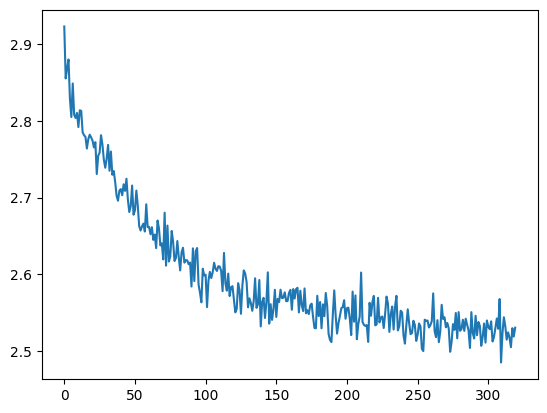

In [4]:
manager.display_evals('losses_batch', log_scale=False)

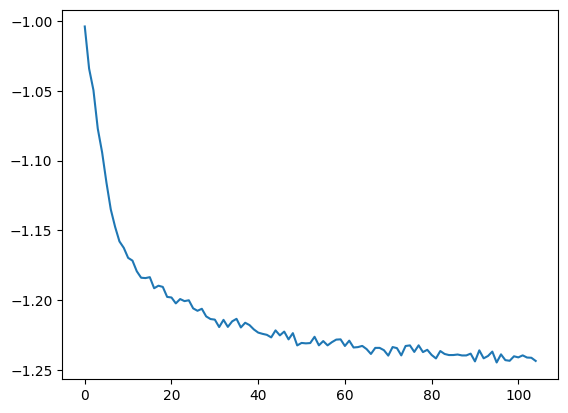

In [7]:
manager.display_evals('losses', log_scale=False)

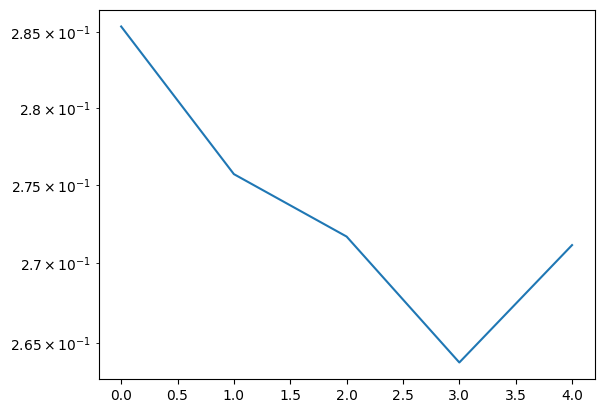

In [5]:
manager.display_evals('wass', log_scale=True)

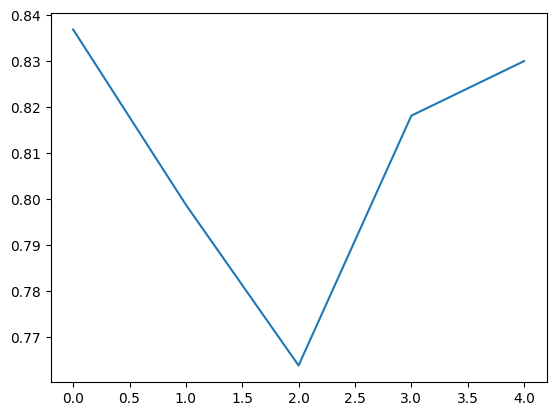

In [6]:
manager.display_evals('recall', log_scale=False)

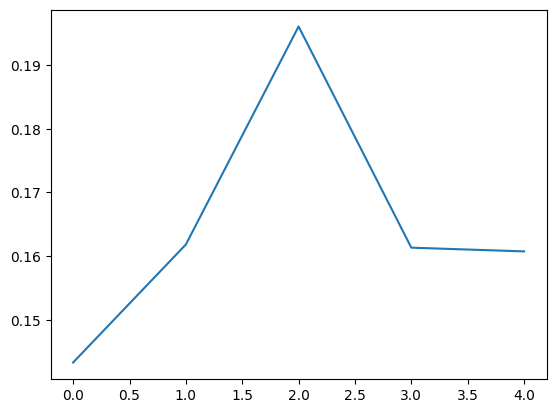

In [7]:
manager.display_evals('precision', log_scale=False)

As usual, $F_1$ score is:
$$ F_1 = 2\dfrac{\textrm{precision} \cdot \textrm{recall}}{\textrm{precision} + \textrm{recall}}$$ 

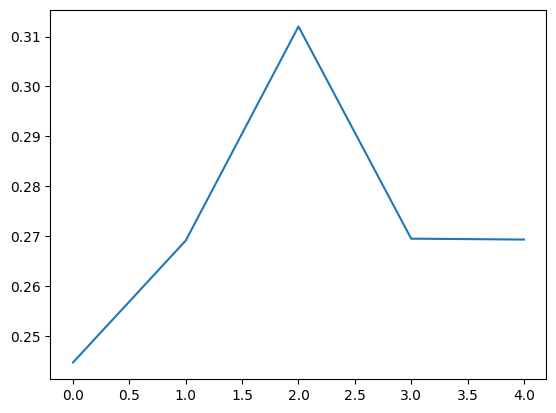

In [8]:
manager.display_evals('f_1_pr', log_scale=False)

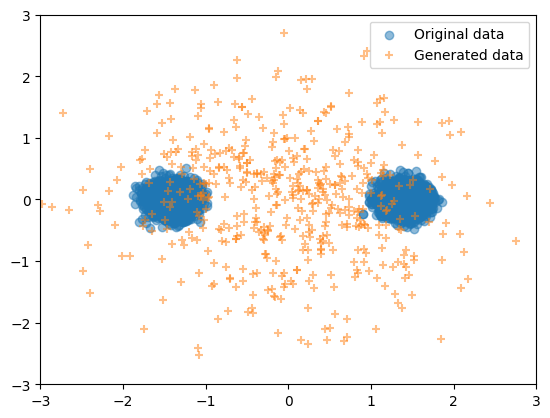

In [9]:
for i in [-1]:
    display(manager.eval.evals['fig'][i])

# Reverse Sampling

## Inspect generated data trajectory - from noise to data distribution

In [4]:
gen_model = Gen.GenerationManager(model, pdmp, data)
gen_model.generate(1000)

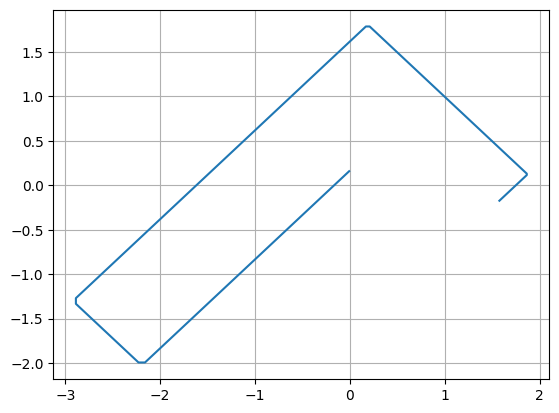

In [5]:
# Look at the position of the particle through time
pos = gen_model.history.squeeze(-2)[:, 0, :2] # squeeze: remove channel dimension
plt.plot(pos[:, 0], pos[:, 1], linestyle='-')
plt.grid(True)
plt.show()

We can now use our GenerationManager object to examine the generated data.

* get animation

'./animation/check.mp4'

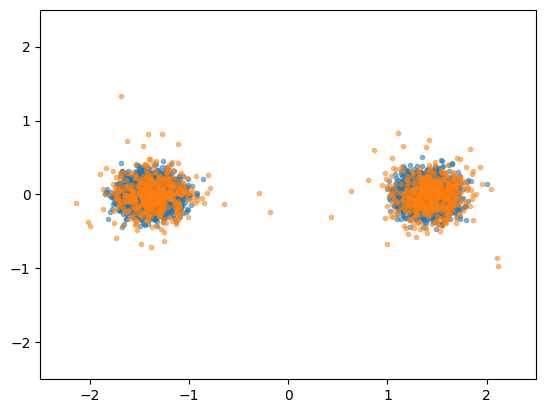

In [6]:
# Use Generation manager object to generate animation from the history of the data
gen_model.animation(generated_data_name = 'check')

* Get plot of the generated data.

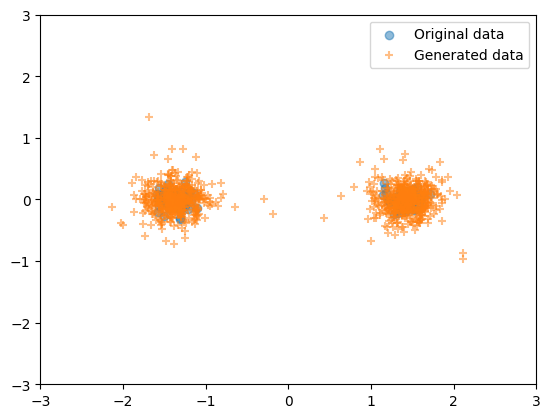

In [8]:
lims = 3
# gen_model.samples = chain[-1, :, :, :2].squeeze(-2) # get the last position of every sample, remove channel dimension
gen_model.get_plot(limit_nb_orig_data = 100, # number of original data to plot
                   xlim = (-lims, lims), ylim = (-lims, lims))